# Import packages and Simulation class

In [1]:
## Allows for figure rendering in notebook
%matplotlib inline
'''
Simulation class for Chapter 7 Tutorial of Intro Network Science book

Copyright 2018 Indiana University and Cambridge University Press
'''

from collections import Counter
from operator import itemgetter
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
import math
import seaborn as sns
import pandas as pd
import math
from itertools import combinations

class StopCondition(StopIteration):
    pass

class Simulation:
    '''Simulate state transitions on a network'''

    def __init__(self, G, initial_state, state_transition,
            stop_condition=None, name=''):
        '''
        Create a Simulation instance.

        Args:
            G: a networkx.Graph instance.
            initial_state: function with signature `initial_state(G)`, that
                accepts a single argument, the Graph, and returns a dictionary
                of all node states. The keys in this dict should be node names
                and the values the corresponding initial node state.
            state_transition: function with signature
                `state_transition(G, current_state)` that accepts two
                arguments, the Graph and a dictionary of current node states,
                and returns a dictionary of updated node states. The keys in
                this dict should be node names and the values the corresponding
                updated node state.
            stop_condition (optional): function with signature
                `stop_condition(G, current_state)` that accepts two arguments,
                the Graph and a dictionary of current node states, and returns
                True if the simulation should be stopped at its current state.

        Keyword Args:
            name (optional): a string used in titles of plots and drawings.

        Raises:
            ValueError: if not all graph nodes have an initial state.
        '''
        self.G = G.copy()
        self._initial_state = initial_state
        self._state_transition = state_transition
        self._stop_condition = stop_condition
        # It's okay to specify stop_condition=False
        if stop_condition and not callable(stop_condition):
            raise TypeError("'stop_condition' should be a function")
        self.name = name or 'Simulation'

        self._states = []
        self._value_index = {}
        self._cmap = plt.cm.get_cmap('tab10')

        self._initialize()

        self._pos = nx.layout.spring_layout(G)

    def _append_state(self, state):
        self._states.append(state)
        # Update self._value_index
        for value in set(state.values()):
            if value not in self._value_index:
                self._value_index[value] = len(self._value_index)

    def _initialize(self):
        if self._initial_state:
            if callable(self._initial_state):
                state = self._initial_state(self.G)
            else:
                state = self._initial_state
            nx.set_node_attributes(self.G, state, 'state')

        if any(self.G.nodes[n].get('state') is None for n in self.G.nodes):
            raise ValueError('All nodes must have an initial state')

        self._append_state(state)

    def _step(self):
        # We're choosing to use the node attributes as the source of truth.
        # This allows the user to manually perturb the network in between steps.
        state = nx.get_node_attributes(self.G, 'state')
        if self._stop_condition and self._stop_condition(self.G, state):
            raise StopCondition
        #state = nx.get_node_attributes(self.G, 'state')
        new_state = self._state_transition(self.G, state)
        #state.update(new_state)
        state = new_state
        nx.set_node_attributes(self.G, state, 'state')
        self._append_state(state)

    def _categorical_color(self, value):
        index = self._value_index[value]
        node_color = self._cmap(index)
        return node_color

    @property
    def steps(self):
        ''' Returns the number of steps the sumulation has run '''
        return len(self._states) - 1

    def state(self, step=-1):
        '''
        Get a state of the simulation; by default returns the current state.

        Args:
            step: the step of the simulation to return. Default is -1, the
            current state.

        Returns:
            Dictionary of node states.

        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        try:
            return self._states[step]
        except IndexError:
            raise IndexError('Simulation step %i out of range' % step)
    
    def props(self,num):
      return self.G.nodes[num]
    
    def graph(self):
      return self.G
    
    def num_nodes(self):
      return self.G.number_of_nodes()

    def draw(self, step=-1, labels=None, **kwargs):
        '''
        Use networkx.draw to draw a simulation state with nodes colored by
        their state value. By default, draws the current state.

        Args:
            step: the step of the simulation to draw. Default is -1, the
            current state.
            kwargs: keyword arguments are passed to networkx.draw()

        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        state = self.state(step)
        node_colors = [self._categorical_color(state[n]) for n in self.G.nodes]
        nx.draw(self.G, pos=self._pos, node_color=node_colors, **kwargs)

        if labels is None:
            labels = sorted(set(state.values()), key=self._value_index.get)
        patches = [mpl.patches.Patch(color=self._categorical_color(l), label=l)
                   for l in labels]
        plt.legend(handles=patches)

        if step == -1:
            step = self.steps
        if step == 0:
            title = 'initial state'
        else:
            title = 'step %i' % (step)
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)

    def plot(self, min_step=None, max_step=None, labels=None, **kwargs):
        '''
        Use pyplot to plot the relative number of nodes with each state at each
        simulation step. By default, plots all simulation steps.

        Args:
            min_step: the first step of the simulation to draw. Default is
                None, which plots starting from the initial state.
            max_step: the last step, not inclusive, of the simulation to draw.
                Default is None, which plots up to the current step.
            labels: ordered sequence of state values to plot. Default is all
                observed state values, approximately ordered by appearance.
            kwargs: keyword arguments are passed along to plt.plot()

        Returns:
            Axes object for the current plot
        '''
        x_range = range(min_step or 0, max_step or len(self._states))
        counts = [Counter(s.values()) for s in self._states[min_step:max_step]]
        if labels is None:
            labels = {k for count in counts for k in count}
            labels = sorted(labels, key=self._value_index.get)

        for label in labels:
            series = [count.get(label, 0) / sum(count.values()) for count in counts]
            plt.plot(x_range, series, label=label, **kwargs)

        title = 'node state proportions'
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)
        plt.xlabel('Simulation step')
        plt.ylabel('Proportion of nodes')
        plt.legend()
        plt.xlim(x_range.start)

        return plt.gca()

    def run(self, steps=1):
        '''
        Run the simulation one or more steps, as specified by the `steps`
        argument. Default is to run a single step.

        Args:
            steps: number of steps to advance the simulation.
        '''
        for _ in range(steps):
            try:
                self._step()
            except StopCondition as e:
                print(
                    "Stop condition met at step %i." % self.steps
                    )
                break


# Growth Module: Below we define the initial network, initial state, and transition state for a network that just grows, demonstrating how the growth occurs in relation to the substrate weights over time.

## Define network

In [6]:
#n=total nodes-1, m= total edges-1, s=initial substrate, h=initial peroxide added
def growth_net(n,m,s):
  # random.seed(100) set seed for reproducibility

  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'s':s}})

  return G

## Initial state

In [3]:
# Function that takes a graph object, assigns all nodes to the "Ox"/Oxidative state,
# then make leaf nodes into the "Re"/Reductive state, these nodes will act as eletrode nodes which will remain reduced at all times.
def initial_growth_state(G):
  
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'

    return state

## Transition state

In [4]:
def transition_growth_state(G, current_state):
    next_state = {}
    growing = [x for x in G.nodes if G.nodes[x]['s'] > 1]
    for g in growing:
        prob = gr
        if random.uniform(0,1) < prob:
              k = len(G.nodes) + 1
              neighbors = list(G.neighbors(g))
              if len(neighbors) <= 10: 
                  G.add_edge(g,k)    
                  s_update = G.nodes[g]['s']/2
                  G.nodes[g]['s'] = s_update
                  G.add_node(k, s = s_update)
                  for x in neighbors:
                      G.add_edge(k,x)
                  current_state[k] = current_state[g]
              else:
                  d_neighbors = random.sample(neighbors,10)
                  G.add_edge(g,k)    
                  s_update = G.nodes[g]['s']/2
                  G.add_node(k, s = s_update)
                  G.nodes[g]['s'] = s_update
                  for x in d_neighbors:
                      G.add_edge(k,x)
                  current_state[k] = current_state[g]

    for node in list(G.nodes):
      next_state[node] = current_state[node]

    return next_state

## Run Simulation

In [7]:
#Set simulation weight increments and thresholds
#Storage
steps = 450
grs = [0.0120, 0.0130, 0.0140] #growth probability
s=20
s1 ={}
#Run multiple times and save
for k in range(len(grs)):
    data = []
    gr = grs[k]
    G = growth_net(50, 100, s)
    sim = Simulation(G, initial_growth_state, transition_growth_state)
    for x in range(0, steps, 1):
        sim.run()
        current_state = sim.state()
        for key in current_state:
            data.append([grs[k], current_state[key], key, x, sim.props(key)['s']])
    s1[grs[k]] = data

# Below are the initial networks, inital states, and transition states for various network configurations demonstrating the difference in diffusion across these topologies. We vary the edge dynamics(fixed vs random) and either include or exclude network growth.

# Diffusion on fixed network

## Define network

In [34]:
#n=total nodes, m= total edges
def diffusion_net(n,m):
  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'h':0}})
  nx.set_node_attributes(G, {0:{'h':100}})
  return G

## Initial state

In [35]:
#Initialize network to have L1 population and one electrode node
def initial_diffusion_state(G):
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'

    return state

## Transition state

In [36]:
def transition_diffusion_state(G, current_state):
    next_state = {}
    J = G.copy()
    #DIFFUSION MODULE
    if transition_diffusion_state.counter >= 1:
        for node in list(G.nodes):
            ci = J.nodes[node]['h'] #set current concentration of this node
            G.nodes[node]['h'] = ci + alpha * (\
                                            sum(J.nodes[j]['h'] for j in J.neighbors(node))\
                                            -ci * J.degree(node)) *Dt
    transition_diffusion_state.counter += 1

    return next_state

## Simulation+plot

In [19]:
alpha = 1
Dt = 0.01
n = 50
h_data = {}
ki_data = {}
for k in range(4):
    G = diffusion_net(n,n*(k+1))
    sim = Simulation(G, initial_diffusion_state, transition_diffusion_state)
    h = []
    transition_diffusion_state.counter = 0
    for x in range(480):
        sim.run()
        h.append(nx.get_node_attributes(sim.graph(),'h'))
    h_data[k] = h
    ki_data[k] = sum([x*nx.degree_histogram(G)[x] for x in range(len(nx.degree_histogram(G)))])/G.number_of_nodes()

In [20]:
hfixed_stdev = {}
for key in h_data.keys():
      stdevs = []
      for x in range(len(h_data[key])):
        stdevs.append(np.std(list(h_data[key][x].values())))
      hfixed_stdev[key] = stdevs

hfixed_mean = {}
for key in h_data.keys():
  avgs = []
  for x in range(len(h_data[key])):
    avgs.append(np.mean(list(h_data[key][x].values())))
  hfixed_mean[key] = avgs


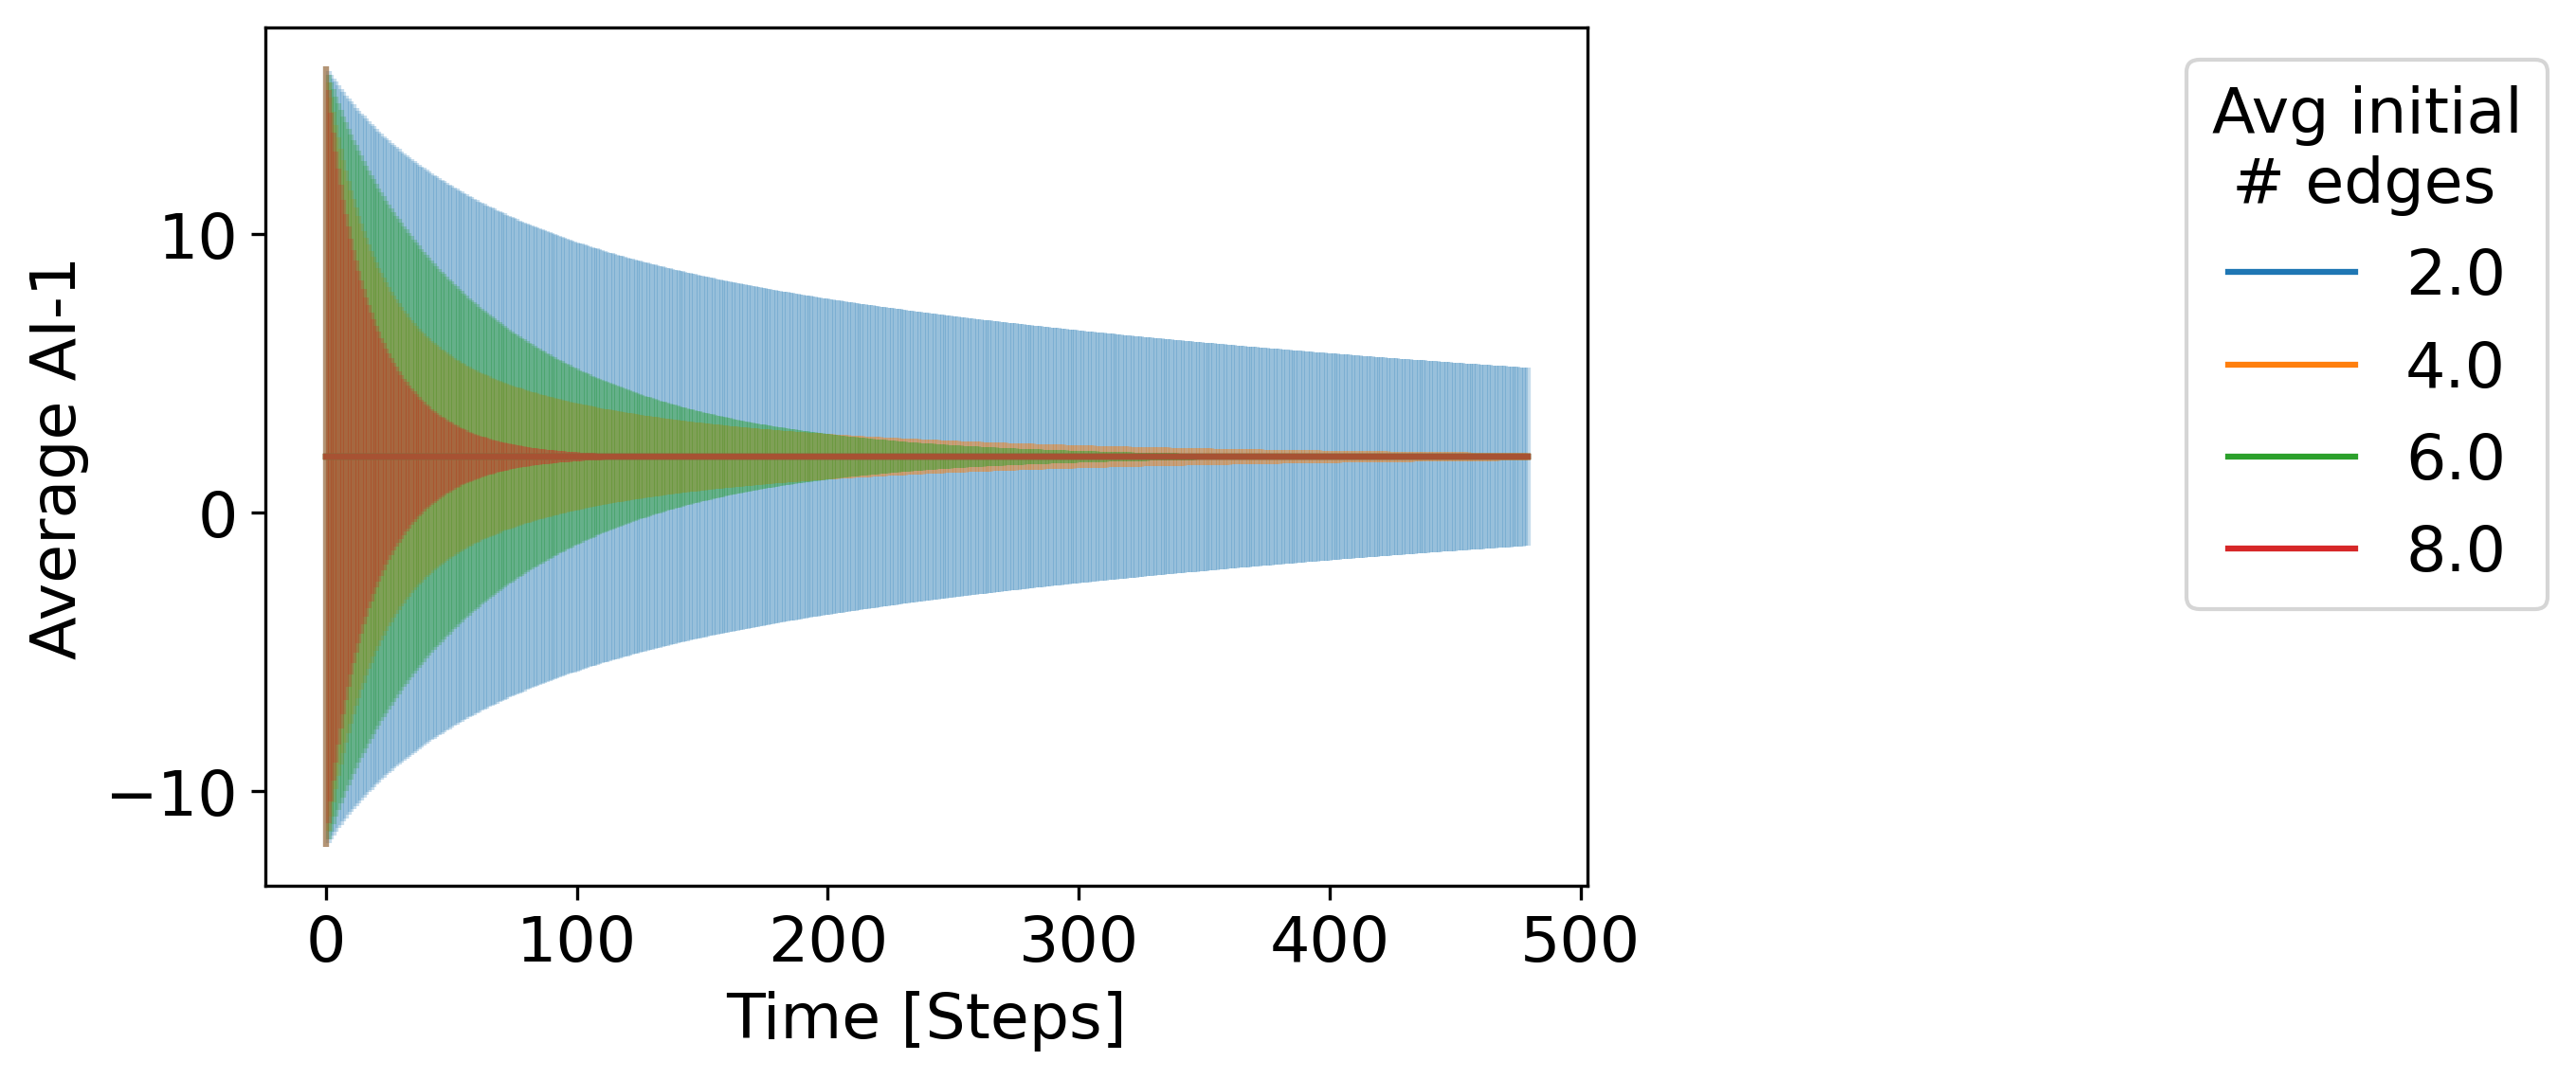

In [24]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for x in range(4):
  plt.errorbar(x = range(480), y = hfixed_mean[x], yerr = hfixed_stdev[x], alpha = 0.25)
  plt.plot(hfixed_mean[x], color=colors[x])
plt.title('')
plt.ylabel('Average AI-1')
plt.xlabel('Time [Steps]')
plt.legend([ki_data[x] for x in ki_data.keys()], title='Avg initial\n # edges', bbox_to_anchor= [1.75,1])
plt.savefig('Fixed errplot',transparent=True, bbox_inches='tight')

# Diffusion from electrode on fixed network

## Define network

In [60]:
#n=total nodes, m= total edges
def diffusion_net(n,m):
  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'h':0}})

  return G

## Initial state

In [61]:
#Initialize network to have L1 population
def initial_diffusion_state(G):
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'

    return state

## Transition state

In [62]:
def transition_diffusion_state(G, current_state):
    next_state = {}
    #For 30 timesteps the single node is producing signal
    if transition_diffusion_state.counter < 30:
        G.nodes[0]['h'] += 40 #for a network size of 50 we add 40 h2o2 weight per timestep
    
    J = G.copy()         
    if transition_diffusion_state.counter >= 1:
        for node in list(G.nodes):
            ci = J.nodes[node]['h'] #set current concentration of this node
            G.nodes[node]['h'] = ci + alpha * (\
                                            sum(J.nodes[j]['h'] for j in J.neighbors(node))\
                                            -ci * J.degree(node)) *Dt

    transition_diffusion_state.counter += 1 
    
    return next_state

## Simulation+plot

In [63]:
alpha = 1
Dt = 0.01
n = 50
h_data = {}
ki_data = {}
for k in range(4):
    transition_diffusion_state.counter = 0
    G = diffusion_net(n,n*(k+1))
    sim = Simulation(G, initial_diffusion_state, transition_diffusion_state)
    h = []
    for x in range(480):
        sim.run()
        h.append(nx.get_node_attributes(sim.graph(),'h'))
    h_data[k] = h
    ki_data[k] = sum([x*nx.degree_histogram(G)[x] for x in range(len(nx.degree_histogram(G)))])/G.number_of_nodes()

In [64]:
hfixed_stdev = {}
for key in h_data.keys():
      stdevs = []
      for x in range(len(h_data[key])):
        stdevs.append(np.std(list(h_data[key][x].values())))
      hfixed_stdev[key] = stdevs

hfixed_mean = {}
for key in h_data.keys():
  avgs = []
  for x in range(len(h_data[key])):
    avgs.append(np.mean(list(h_data[key][x].values())))
  hfixed_mean[key] = avgs


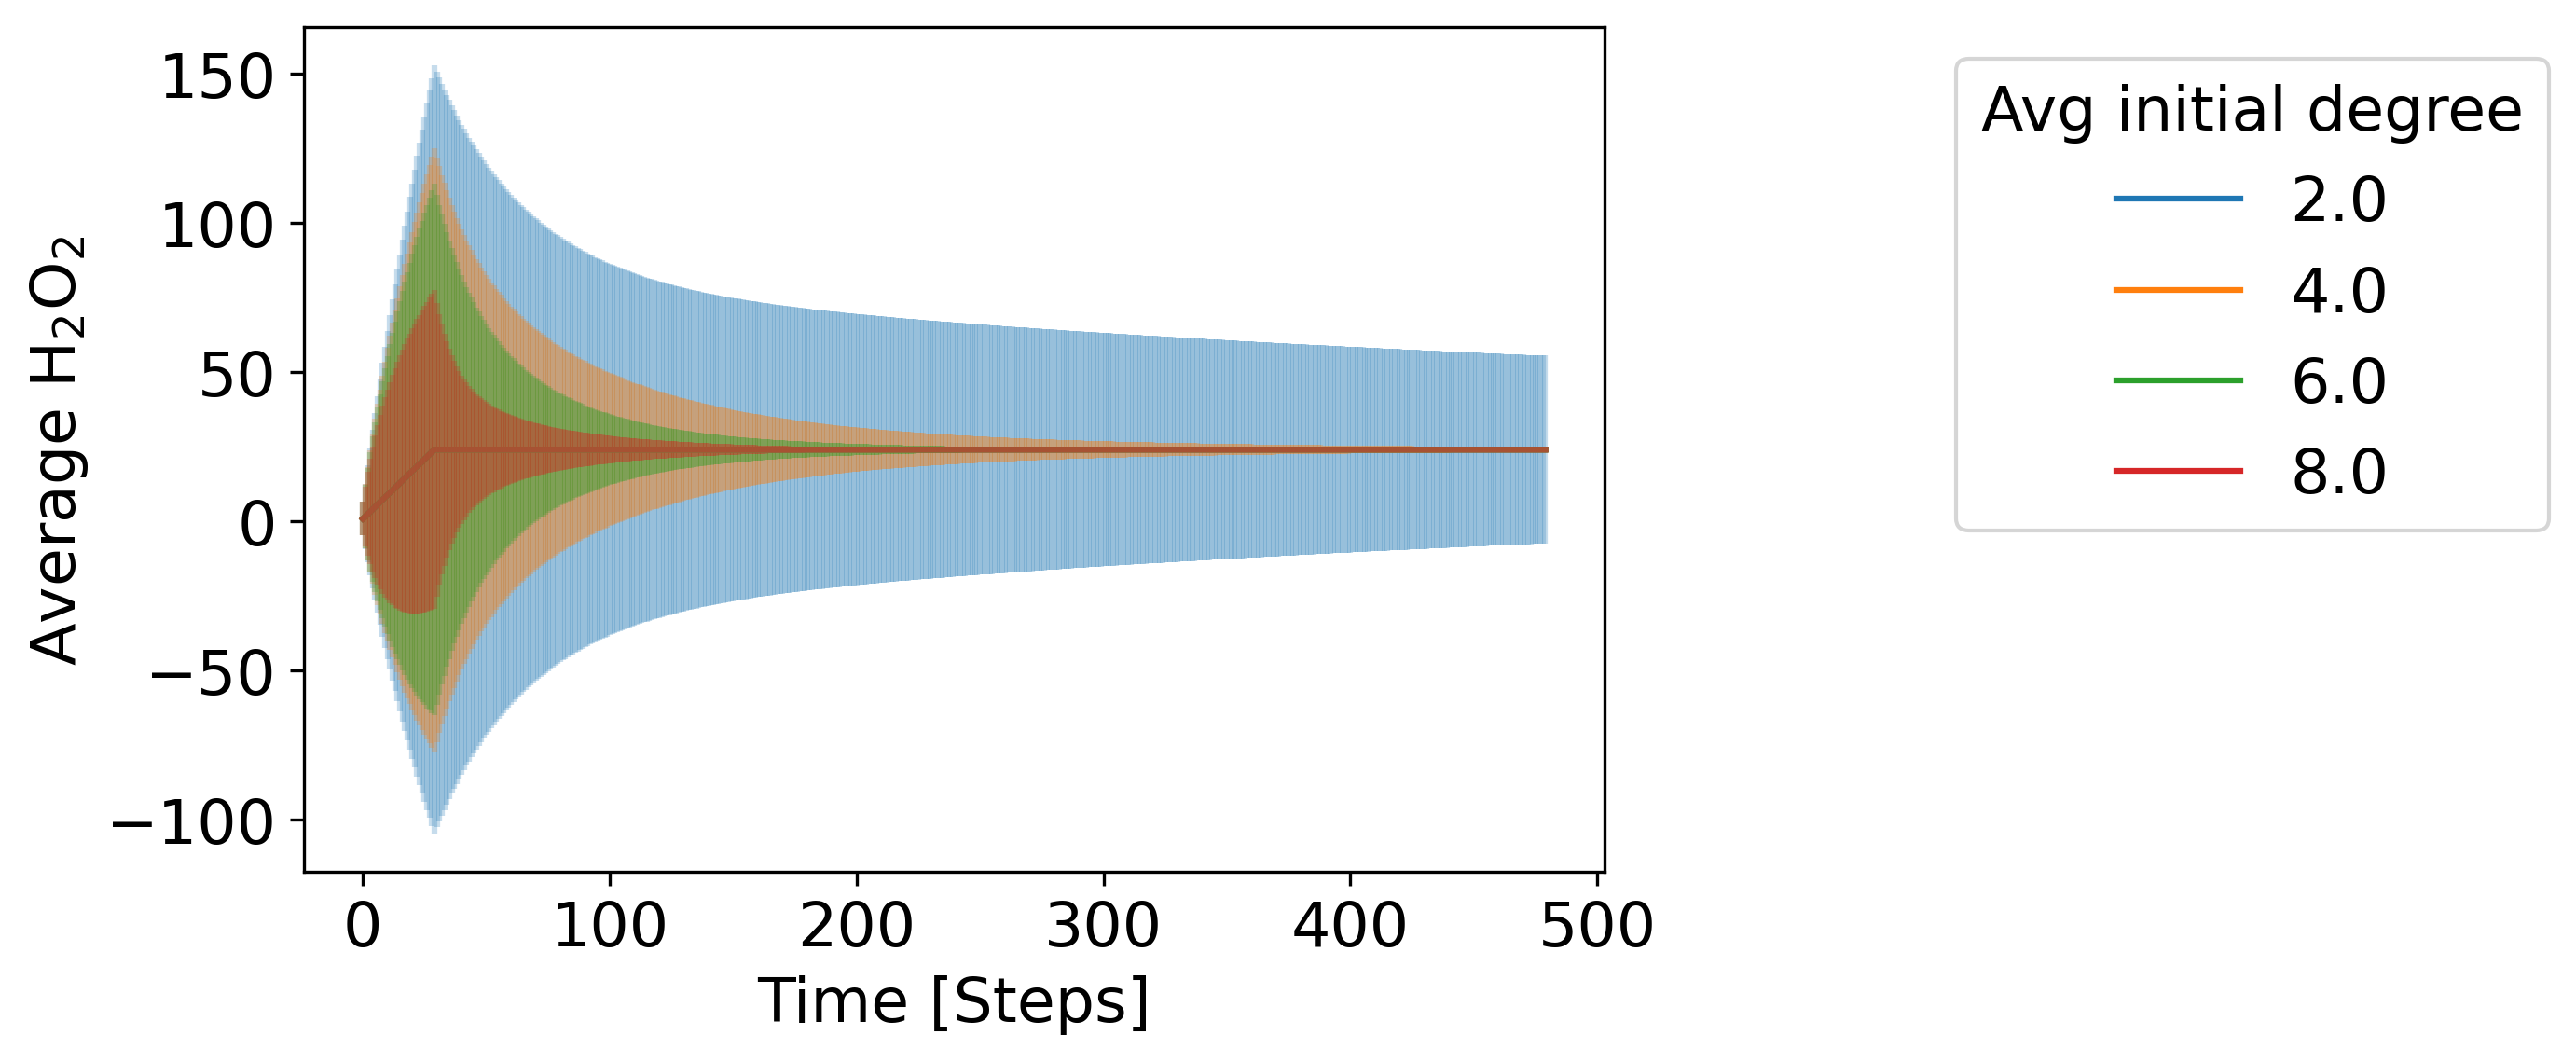

In [65]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for x in range(4):
  plt.errorbar(x = range(480), y = hfixed_mean[x], yerr = hfixed_stdev[x], alpha = 0.25, color = colors[x])
  plt.plot(hfixed_mean[x], colors[x])
plt.title('')
plt.ylabel('Average $\mathregular{H_{2}O_{2}}$')
plt.xlabel('Time [Steps]')
plt.legend([ki_data[x] for x in ki_data.keys()], title='Avg initial degree', bbox_to_anchor = [1.75,1])
plt.savefig('Fixed errplot from electrode',transparent=True, bbox_inches='tight')

# Diffusion+Randomized Edges

## Define network

In [25]:
#n=total nodes, m= total edges
def diffusion_random_net(n,m):

  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'h':0}})
  nx.set_node_attributes(G, {0:{'h':100}})  #assign one node to have 100 h2o2 weight
  return G

## Initial state

In [26]:
#Initialize network to have L1 population 
def initial_diffusion_random_state(G):
   # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'

    return state

## Transition state

In [27]:
from itertools import combinations
def transition_diffusion_random_state(G, current_state):
    next_state = {}
    J = G.copy()
    #DIFFUSION MODULE
    if transition_diffusion_random_state.counter >= 1:
        for node in list(G.nodes):
            ci = J.nodes[node]['h'] #set current concentration of this node
            G.nodes[node]['h'] = ci + alpha * (\
                                            sum(J.nodes[j]['h'] for j in J.neighbors(node))\
                                            -ci * J.degree(node)) *Dt
    transition_diffusion_random_state.counter += 1
    
    #EDGE RANDOMIZAION
    m = G.number_of_edges()
    G.remove_edges_from(G.edges())
    edges = [comb for comb in combinations(G.nodes(),2)]
    new_edges = random.sample(edges, m)
    G.add_edges_from(new_edges)

    return next_state

## Simulation+plot

In [28]:
alpha = 1
Dt = 0.01
n = 50
h_data = {}
k_data = {}
for k in range(4):
    transition_diffusion_random_state.counter = 0
    G = diffusion_random_net(n,n*(k+1))
    sim = Simulation(G, initial_diffusion_random_state, transition_diffusion_random_state)
    h = []
    avg_degree = []
    for x in range(480):
        sim.run()
        h.append(nx.get_node_attributes(sim.graph(),'h'))
        avg_degree.append(sum([x*nx.degree_histogram(sim.graph())[x] for x in range(len(nx.degree_histogram(sim.graph())))])/sim.graph().number_of_nodes())
    h_data[k] = h
    k_data[k] = avg_degree

In [29]:
hrandom_stdev = {}
for key in h_data.keys():
  stdevs = []
  for x in range(len(h_data[key])):
    stdevs.append(np.std(list(h_data[key][x].values())))
  hrandom_stdev[key] = stdevs

hrandom_mean = {}
for key in h_data.keys():
  avgs = []
  for x in range(len(h_data[key])):
    avgs.append(np.mean(list(h_data[key][x].values())))
  hrandom_mean[key] = avgs


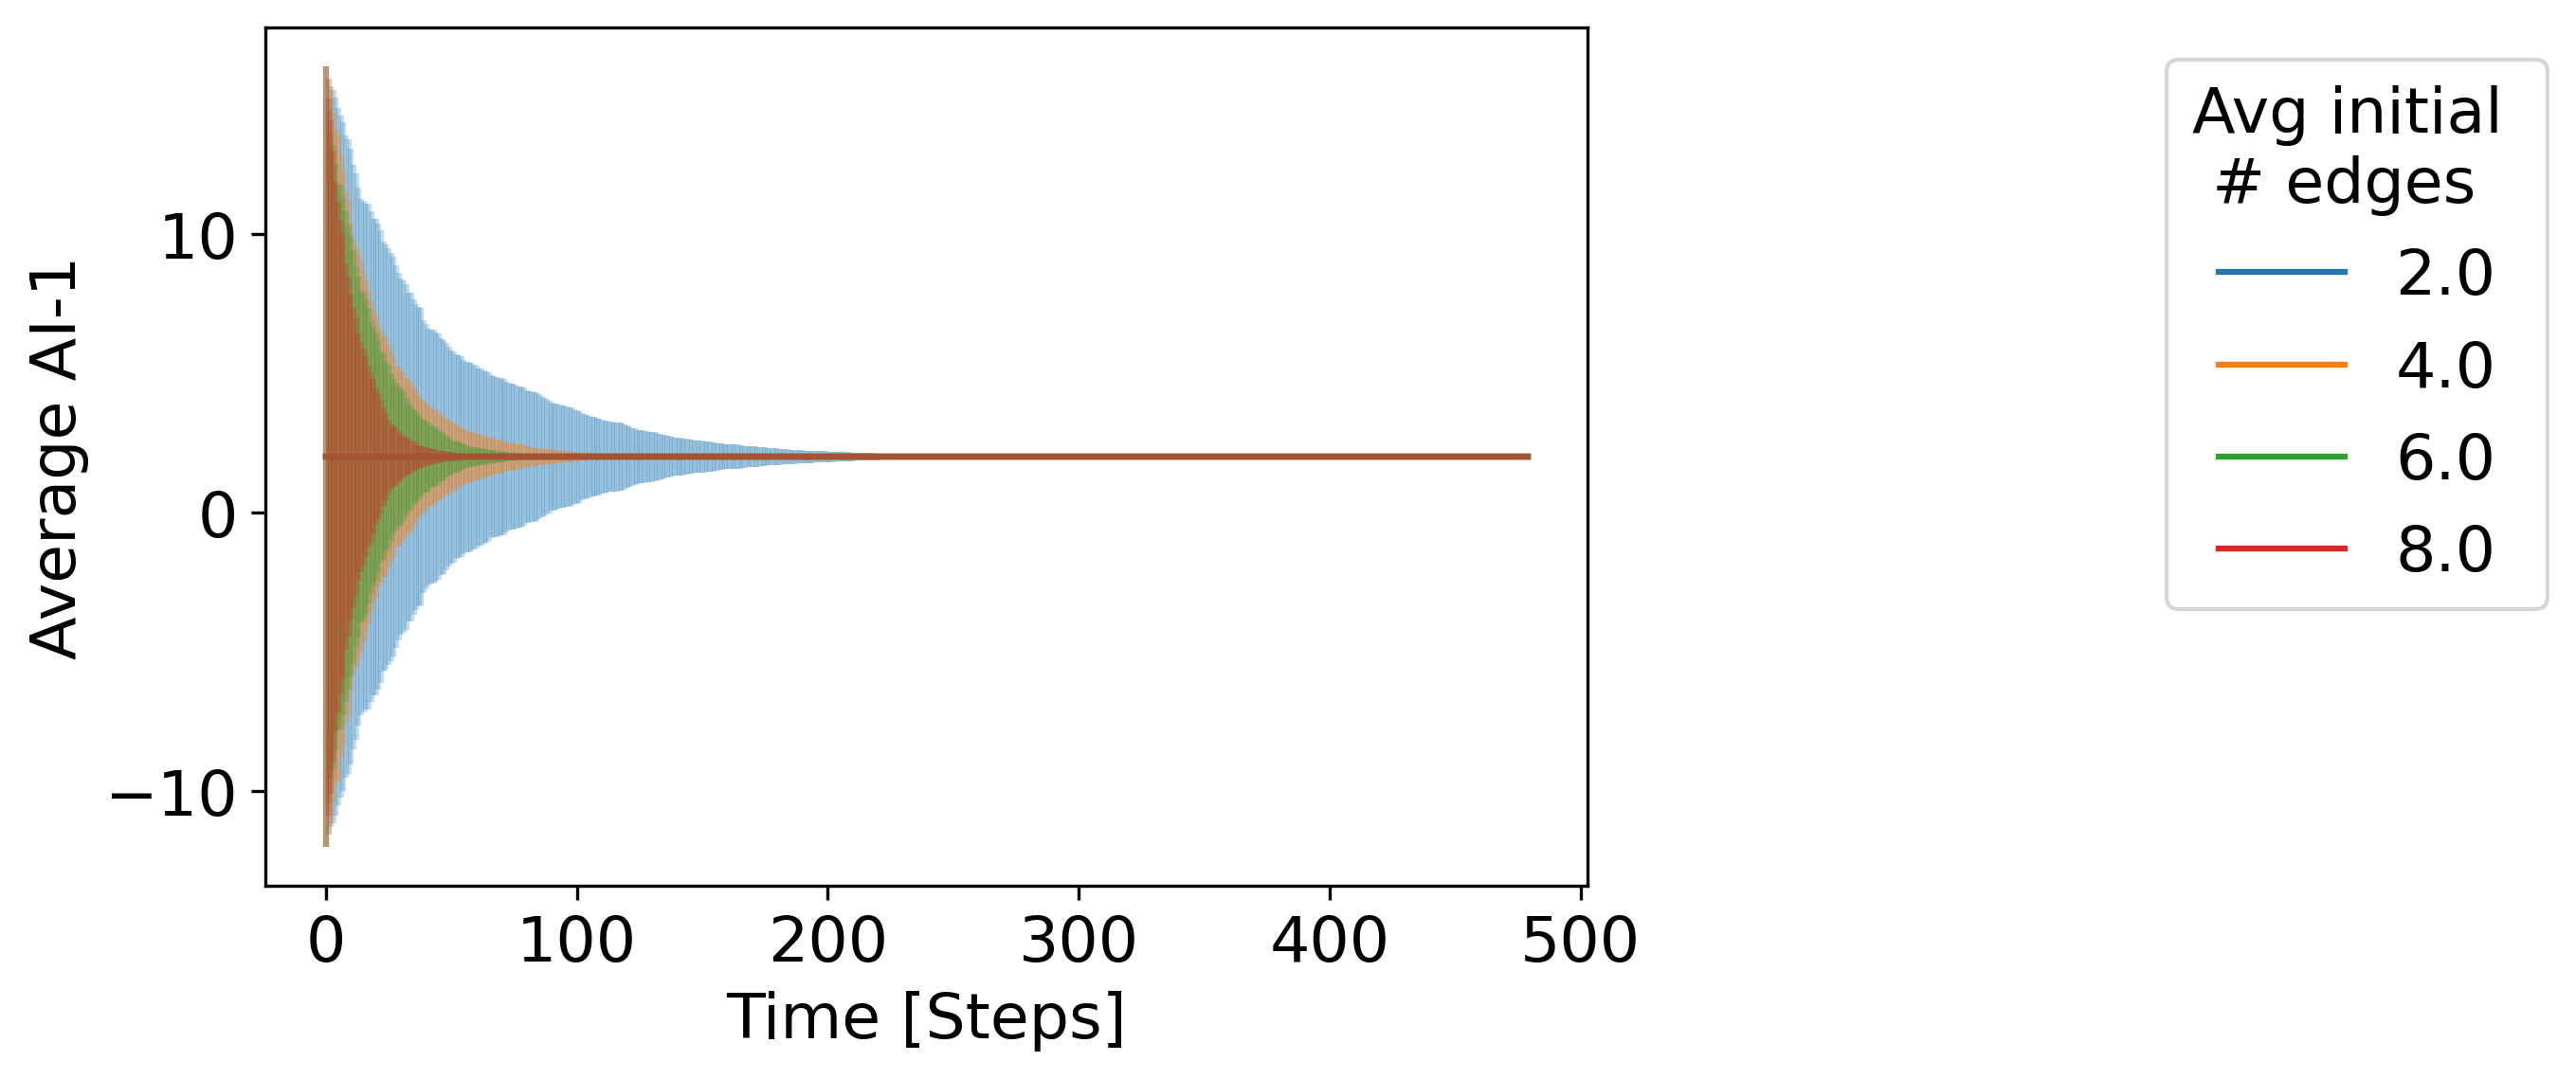

In [31]:
for x in range(4):
  plt.errorbar(x = range(480), y = hrandom_mean[x], yerr = hrandom_stdev[x], alpha = 0.25, color = colors[x])
  plt.plot(hrandom_mean[x], color=colors[x])

plt.title('')
plt.ylabel('Average AI-1')
plt.xlabel('Time [Steps]')
plt.legend([2.0,4.0,6.0,8.0], title='Avg initial \n # edges', bbox_to_anchor=[1.75,1])
plt.savefig('Random errplot',transparent=True, bbox_inches='tight')

# Diffusion+Randomized Edges from electrode

## Define network

In [22]:
#n=total nodes, m= total edges
def diffusion_random_net(n,m):
  # random.seed(100) set seed for reproducibility

  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'h':0}})
    
  return G

## Initial state

In [23]:
#Initialize network to have L1 population and one electrode node
def initial_diffusion_random_state(G):
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'
    state[0] = 'Electrode'
    return state

## Transition state

In [24]:
from itertools import combinations
def transition_diffusion_random_state(G, current_state):
    next_state = {}
    #Electrode node makes h2o2 for 30 timesteps
    if transition_diffusion_random_state.counter < 30:
        G.nodes[0]['h'] += 40
    
    #DIFFUSION MODULE
    J = G.copy()         
    if transition_diffusion_random_state.counter >= 1:
        for node in list(G.nodes):
            ci = J.nodes[node]['h'] #set current concentration of this node
            G.nodes[node]['h'] = ci + alpha * (\
                                            sum(J.nodes[j]['h'] for j in J.neighbors(node))\
                                            -ci * J.degree(node)) *Dt
    
    transition_diffusion_random_state.counter += 1
    
    #EDGE RANDOMIZATION
    m = G.number_of_edges()
    G.remove_edges_from(G.edges())
    edges = [comb for comb in combinations(G.nodes(),2)]
    new_edges = random.sample(edges, m)
    G.add_edges_from(new_edges)

    return next_state

## Simulation+plot

In [25]:
alpha = 1
Dt = 0.01
n = 50
h_data = {}
k_data = {}
for k in range(4):
  transition_diffusion_random_state.counter = 0
  G = diffusion_random_net(n,n*(k+1))
  sim = Simulation(G, initial_diffusion_random_state, transition_diffusion_random_state)
  h = []
  avg_degree = []
  for x in range(480):
      sim.run()
      h.append(nx.get_node_attributes(sim.graph(),'h'))
      avg_degree.append(sum([x*nx.degree_histogram(sim.graph())[x] for x in range(len(nx.degree_histogram(sim.graph())))])/sim.graph().number_of_nodes())
  h_data[k] = h
  k_data[k] = avg_degree

In [26]:
hrandom_stdev = {}
for key in h_data.keys():
  stdevs = []
  for x in range(len(h_data[key])):
    stdevs.append(np.std(list(h_data[key][x].values())))
  hrandom_stdev[key] = stdevs

hrandom_mean = {}
for key in h_data.keys():
  avgs = []
  for x in range(len(h_data[key])):
    avgs.append(np.mean(list(h_data[key][x].values())))
  hrandom_mean[key] = avgs


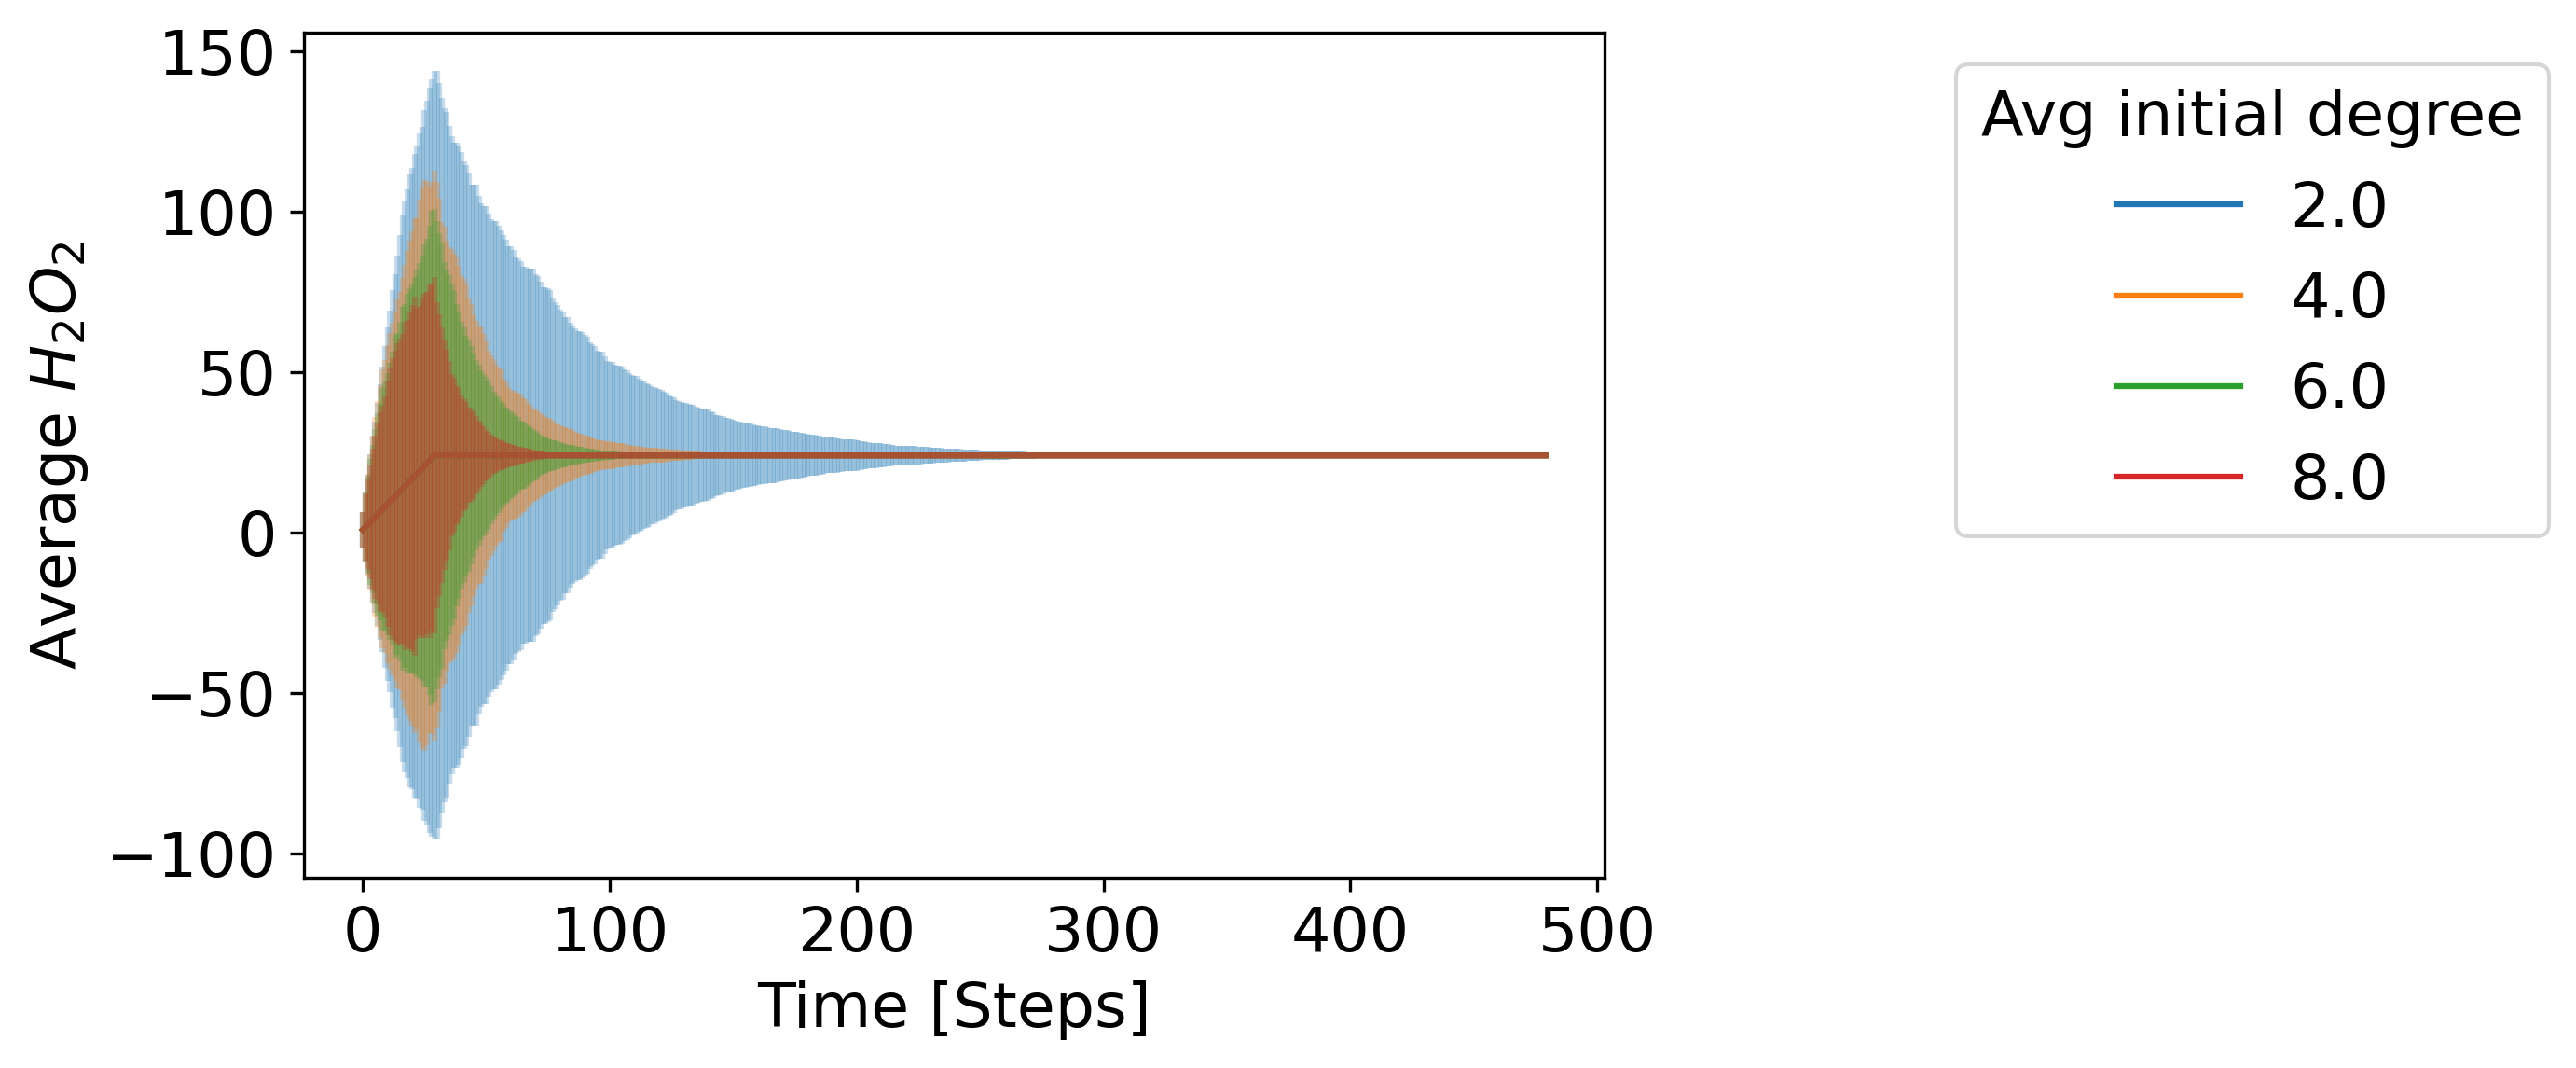

In [27]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for x in range(4):
  plt.errorbar(x = range(480), y = hrandom_mean[x], yerr = hrandom_stdev[x], alpha = 0.25, color = colors[x])
  plt.plot(hrandom_mean[x], colors[x])
plt.title('')
plt.ylabel('Average $H_{2}O_{2}$')
plt.xlabel('Time [Steps]')
plt.legend([2.0,4.0,6.0,8.0], title='Avg initial degree', bbox_to_anchor = [1.75,1])
plt.savefig('Diffusion randomized from electrode errplot',transparent=True, bbox_inches='tight')

# Diffusion with Growth

## Define network

In [37]:
#n=total nodes, m= total edges
def growth_diffusion_net(n,m,s):

  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'h':0, 's':s}})
  nx.set_node_attributes(G, {0:{'h':100}}) #assign one node to 100, source of signal
  return G

## Initial state

In [38]:
#Initialize network to have L1 population 
def initial_growth_diffusion_state(G):
  
    #random.seed(100)
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'

    return state

## Transition state

In [39]:
def transition_growth_diffusion_state(G, current_state):
    next_state = {}
    
    #DIFFUSION MODULE
    J = G.copy()
    for node in list(G.nodes):
        ci = J.nodes[node]['h'] #set current concentration of this node
        G.nodes[node]['h'] = ci + alpha * (\
                                        np.sum(J.nodes[g]['h'] for g in J.neighbors(node))\
                                        -ci * J.degree(node)) *Dt
    
    #GROWTH MODULE
    growing = [x for x in G.nodes if G.nodes[x]['s'] >= 1]
    for g in growing:
        prob = gr
        if random.uniform(0,1) < prob:
            k = len(G.nodes) + 1
            neighbors = list(G.neighbors(g))
            if len(neighbors) <= 10:
                    G.add_edge(g,k)    
                    s_update = G.nodes[g]['s']/2
                    h_update = G.nodes[g]['h']/2
                    G.nodes[g]['s'] = s_update
                    G.nodes[g]['h'] = h_update
                    G.add_node(k, h = h_update, s = s_update)
                    for x in neighbors:
                        G.add_edge(k,x)
                    current_state[k] = current_state[g]

            else:
                    d_neighbors = random.sample(neighbors,10)
                    G.add_edge(g,k)    
                    s_update = G.nodes[g]['s']/2
                    h_update = G.nodes[g]['h']/2
                    G.add_node(k, h = h_update, s = s_update)
                    G.nodes[g]['s'] = s_update
                    G.nodes[g]['h'] = h_update
                    for x in d_neighbors:
                        G.add_edge(k,x)
                    current_state[k] = current_state[g]
                
    next_state = current_state
    
    return next_state

## Simulation+plot

In [36]:
alpha = 1
Dt = 0.01
gr = 0.01
n = 50
h_data = {}
ki_data = {}
d_data = {}
node_data = {}
for k in range(4):
  G = growth_diffusion_net(n,n*(k+1),10)
  sim = Simulation(G, initial_growth_diffusion_state, transition_growth_diffusion_state)
  h = []
  deg = []
  node = []
  for x in range(480):
      sim.run()
      h.append(nx.get_node_attributes(sim.graph(),'h'))
      deg.append(sim.graph().number_of_edges)
      node.append(sim.graph().number_of_nodes)
  h_data[k] = h
  d_data[k] = deg
  node_data[k] = node
  ki_data[k] = sum([x*nx.degree_histogram(G)[x] for x in range(len(nx.degree_histogram(G)))])/G.number_of_nodes()

<ipython-input-34-1326df05fcff>:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(J.nodes[g]['h'] for g in J.neighbors(node))\


In [37]:
hgrowth_stdev = {}
for key in h_data.keys():
  stdevs = []
  for x in range(len(h_data[key])):
    stdevs.append(np.std(list(h_data[key][x].values())))
  hgrowth_stdev[key] = stdevs

hgrowth_mean = {}
for key in h_data.keys():
  avgs = []
  for x in range(len(h_data[key])):
    avgs.append(np.mean(list(h_data[key][x].values())))
  hgrowth_mean[key] = avgs


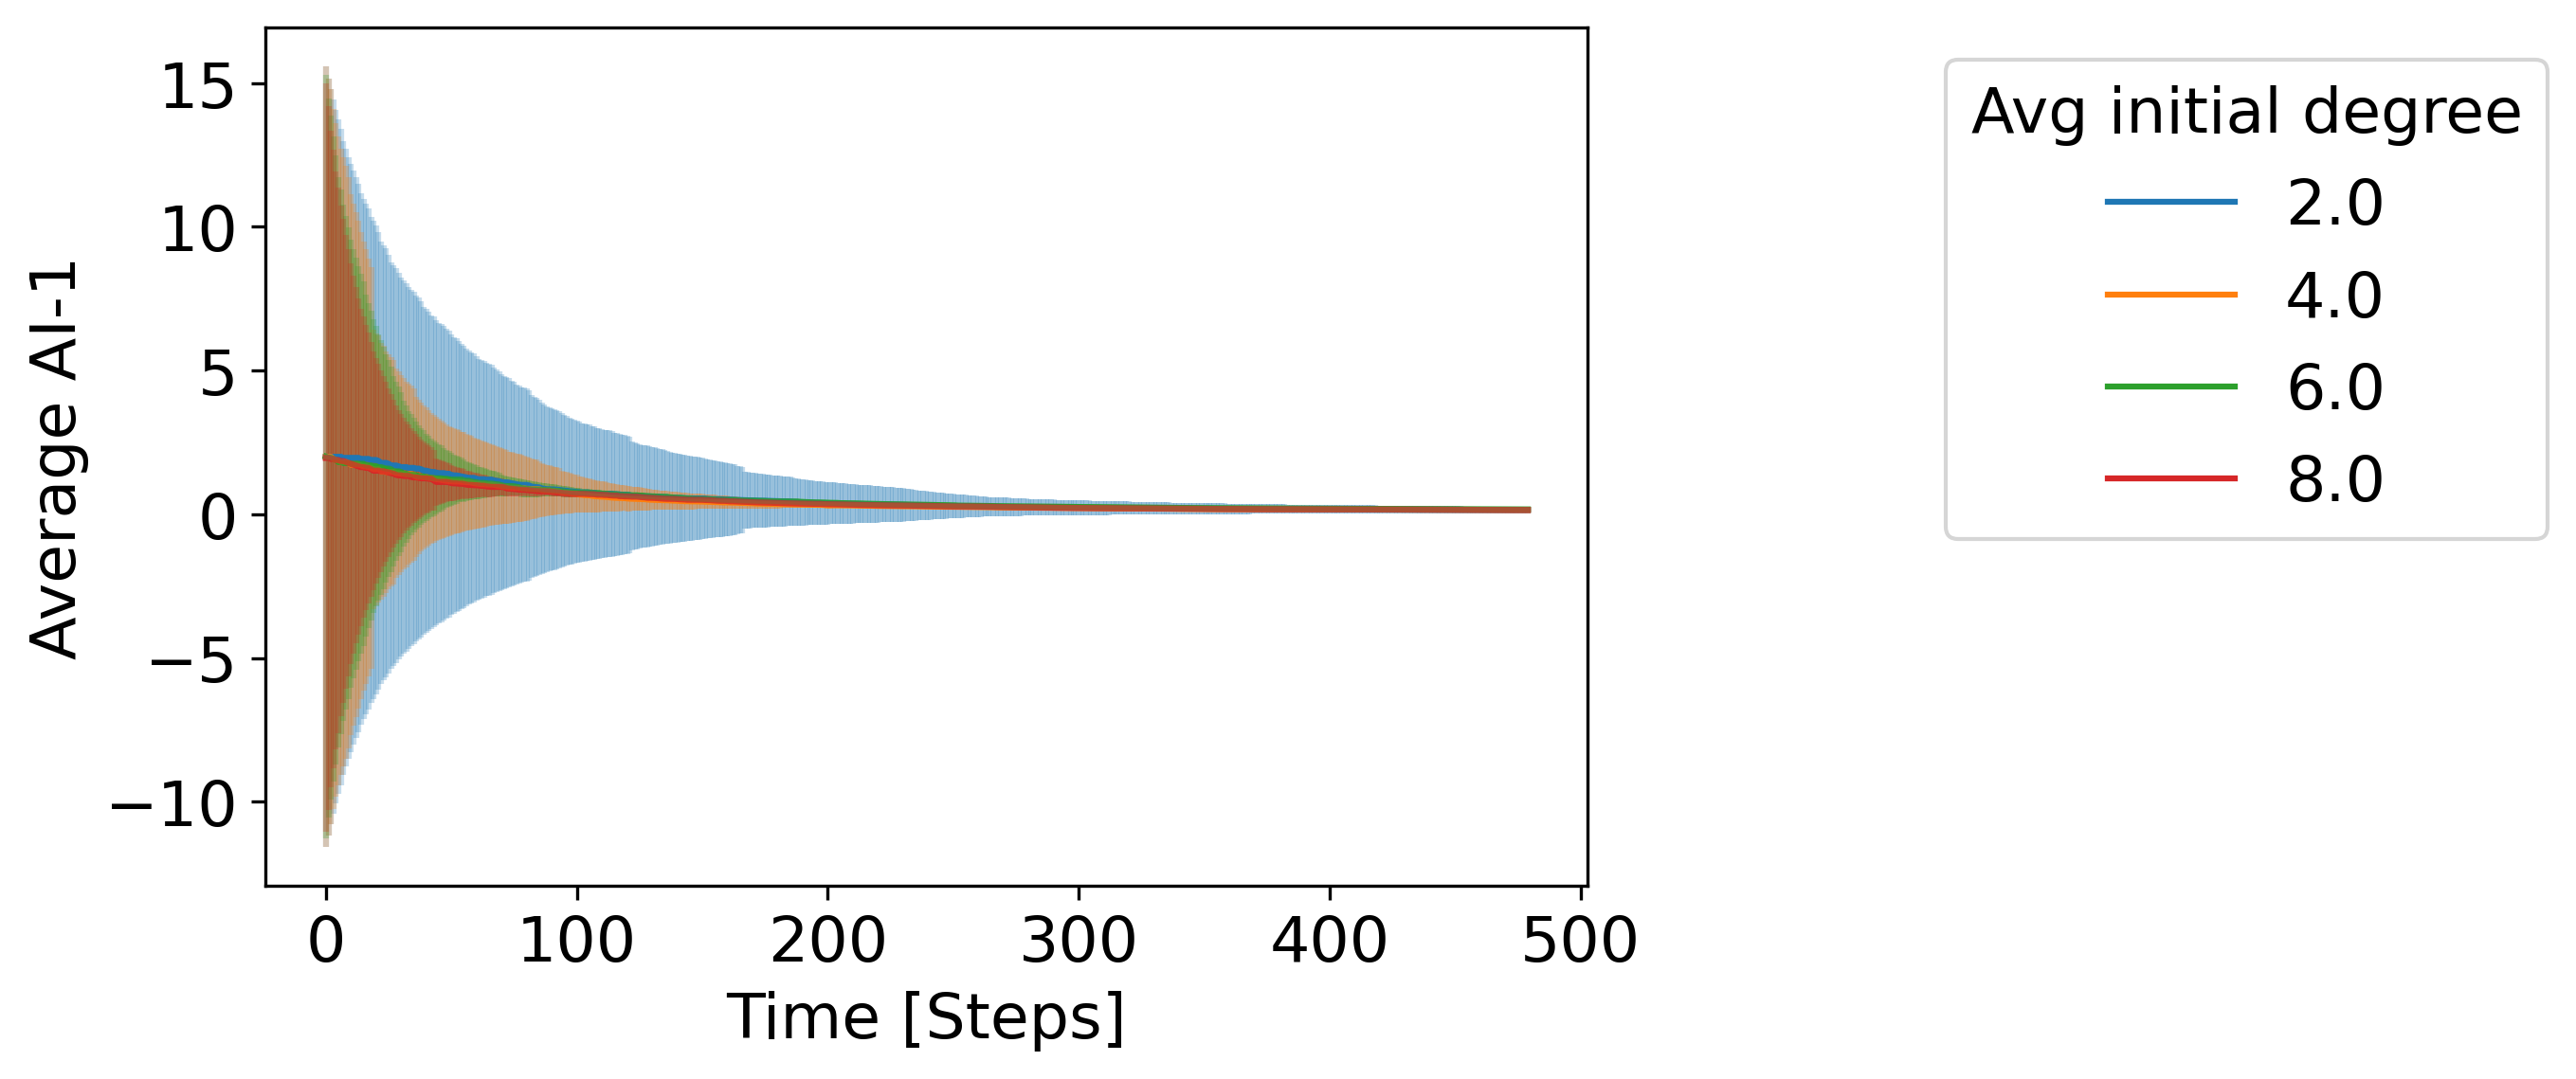

In [38]:
for x in range(4):
  plt.errorbar(x = range(480), y = hgrowth_mean[x], yerr = hgrowth_stdev[x], alpha = 0.25, color = colors[x])
  plt.plot(hgrowth_mean[x], color = colors[x])
plt.title('')
plt.ylabel('Average AI-1')
plt.xlabel('Time [Steps]')
plt.legend([ki_data[x] for x in ki_data.keys()], title='Avg initial degree', bbox_to_anchor = [1.75,1])
plt.savefig('Growth errplot',transparent=True, bbox_inches='tight')

# Diffusion with Growth from electrode

## Define network

In [3]:
#n=total nodes, m= total edges
def growth_diffusion_net(n,m,s):
  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'h':0, 's':s}})
  
  return G

## Initial state

In [4]:
#Initialize network to have L1 population and one electrode node
def initial_growth_diffusion_state(G):
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'
    state[0] = 'Electrode'
    return state

## Transition state

In [5]:
def transition_growth_diffusion_state(G, current_state):
    next_state = {}
    #Electrode makes h2o2 for 30 timesteps
    if transition_growth_diffusion_state.counter < 30:
        G.nodes[0]['h'] += 40
    
    #DIFFUSION MODULE
    J = G.copy()
    for node in list(G.nodes):
        ci = J.nodes[node]['h'] #set current concentration of this node
        G.nodes[node]['h'] = ci + alpha * (\
                                        sum(J.nodes[g]['h'] for g in J.neighbors(node))\
                                        -ci * J.degree(node)) *Dt

    #GROWTH MODULE
    if transition_growth_diffusion_state.counter > 30:    
        growing = [x for x in G.nodes if G.nodes[x]['s'] >= 1]
        for g in growing:
            prob = gr
            if random.uniform(0,1) < prob:
                k = len(G.nodes) + 1
                neighbors = list(G.neighbors(g))
                if len(neighbors) <= 10:
                        G.add_edge(g,k)    
                        s_update = G.nodes[g]['s']/2
                        h_update = G.nodes[g]['h']/2
                        G.nodes[g]['s'] = s_update
                        G.nodes[g]['h'] = h_update
                        G.add_node(k, h = h_update, s = s_update)
                        for x in neighbors:
                            G.add_edge(k,x)
                        current_state[k] = current_state[g]

                else:
                        d_neighbors = random.sample(neighbors,10)
                        G.add_edge(g,k)    
                        s_update = G.nodes[g]['s']/2
                        h_update = G.nodes[g]['h']/2
                        G.add_node(k, h = h_update, s = s_update)
                        G.nodes[g]['s'] = s_update
                        G.nodes[g]['h'] = h_update
                        for x in d_neighbors:
                            G.add_edge(k,x)
                        current_state[k] = current_state[g]
    
    transition_growth_diffusion_state.counter += 1
    next_state = current_state
    
    return next_state

## Simulation+plot

In [8]:
alpha = 1
Dt = 0.01
gr = 0.01
n = 50
h_data = {}
ki_data = {}
d_data = {}
node_data = {}
for k in range(4):
    transition_growth_diffusion_state.counter = 0
    G = growth_diffusion_net(n,n*(k+1),10)
    sim = Simulation(G, initial_growth_diffusion_state, transition_growth_diffusion_state)
    h = []
    deg = []
    node = []
    for x in range(480):
        sim.run()
        h.append(nx.get_node_attributes(sim.graph(),'h'))
        deg.append(sim.graph().number_of_edges)
        node.append(sim.graph().number_of_nodes)
        h_data[k] = h
        d_data[k] = deg
        node_data[k] = node
        ki_data[k] = sum([x*nx.degree_histogram(G)[x] for x in range(len(nx.degree_histogram(G)))])/G.number_of_nodes()

In [9]:
hgrowth_stdev = {}
for key in h_data.keys():
  stdevs = []
  for x in range(len(h_data[key])):
    stdevs.append(np.std(list(h_data[key][x].values())))
  hgrowth_stdev[key] = stdevs

hgrowth_mean = {}
for key in h_data.keys():
  avgs = []
  for x in range(len(h_data[key])):
    avgs.append(np.mean(list(h_data[key][x].values())))
  hgrowth_mean[key] = avgs


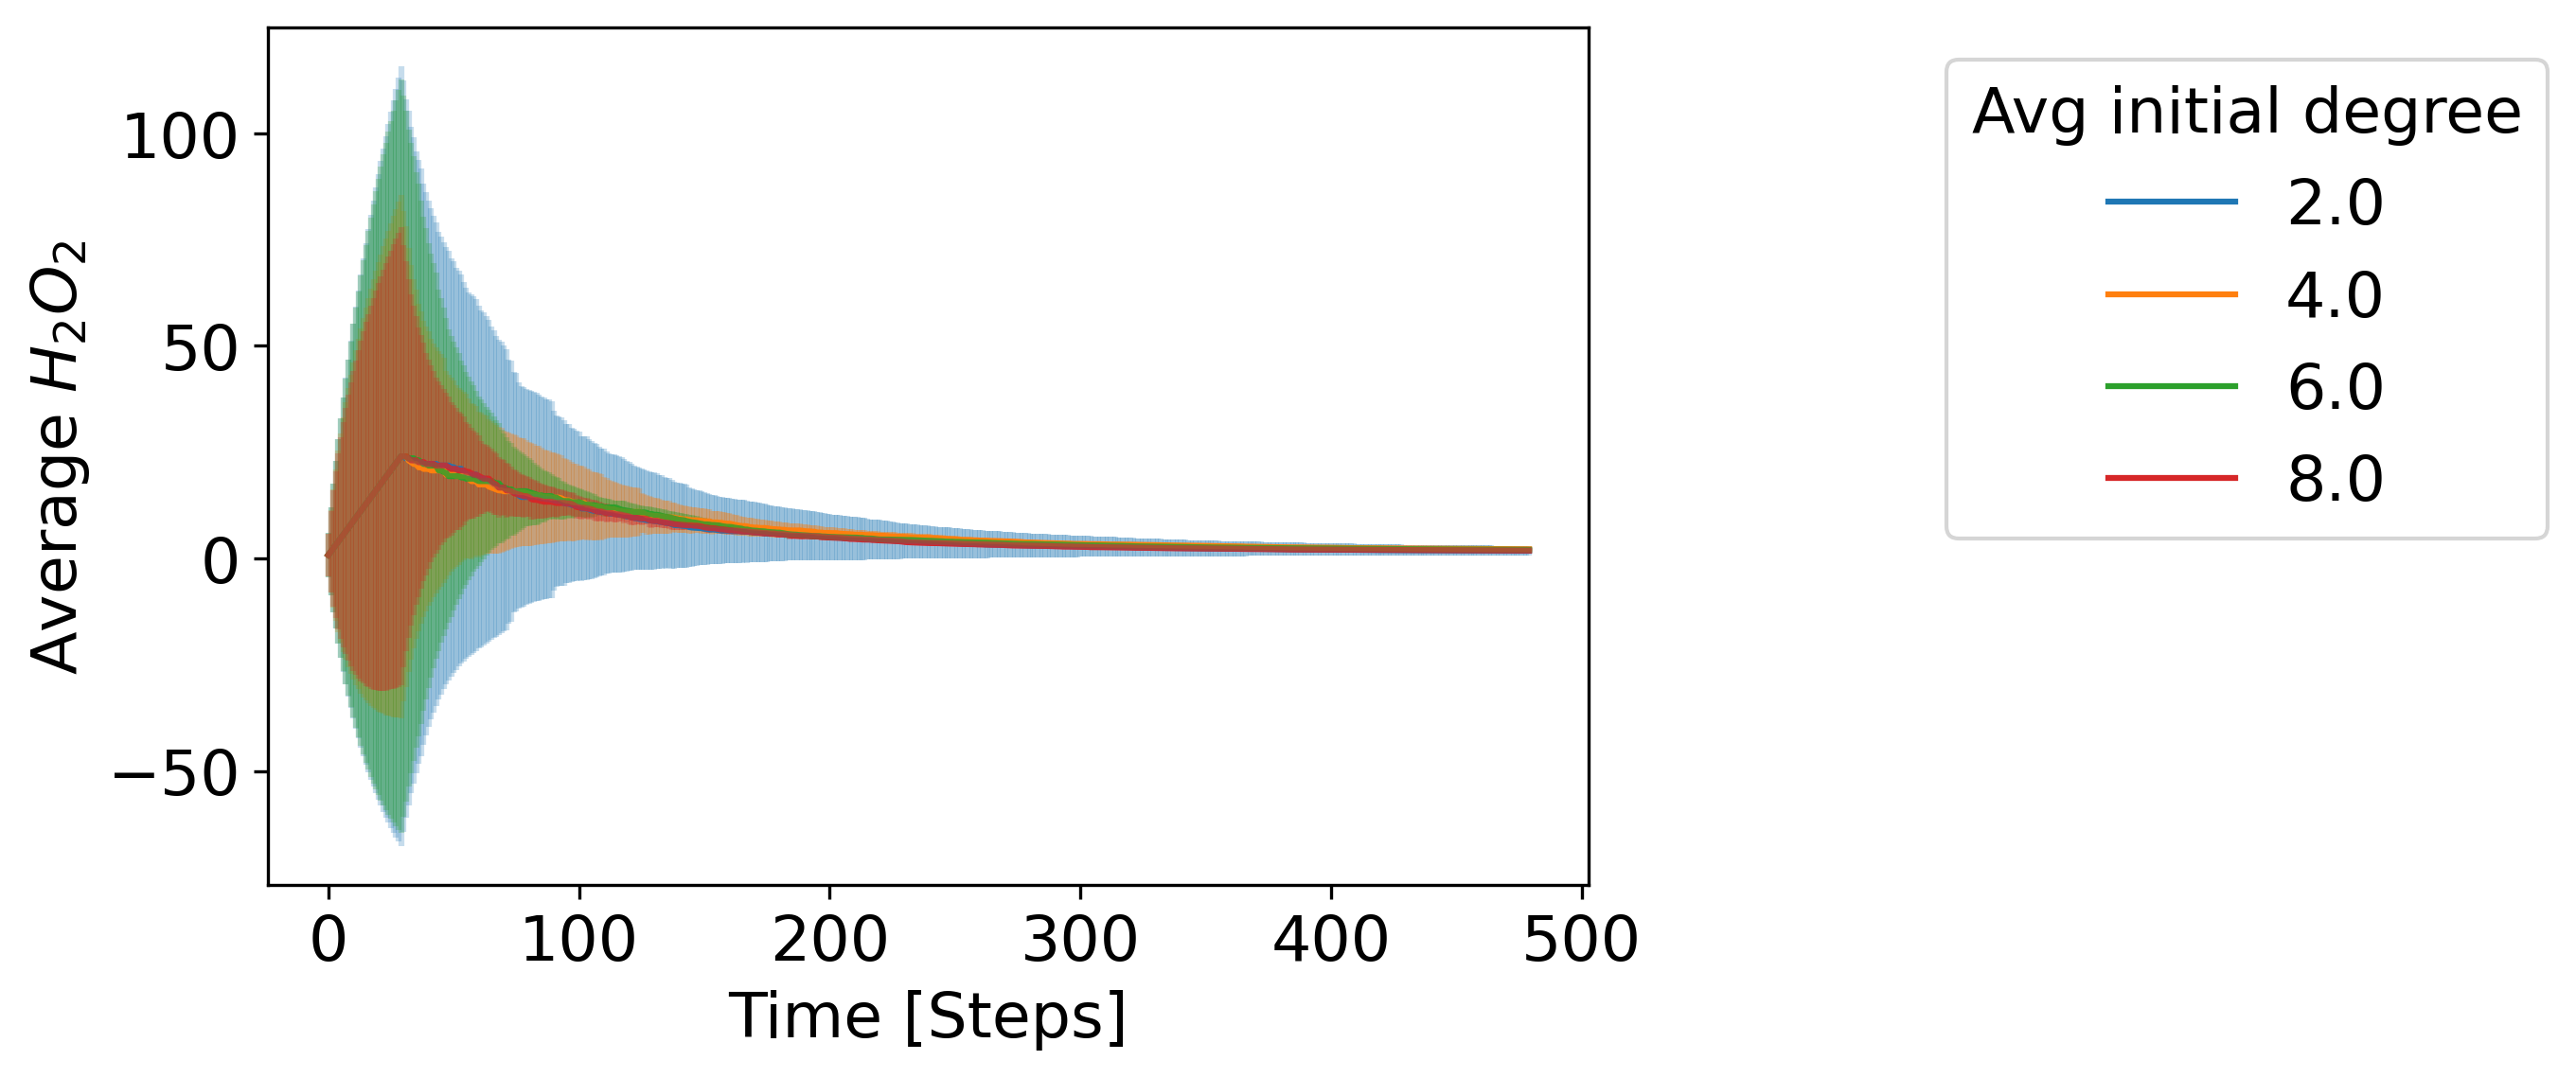

In [10]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for x in range(4):
  plt.errorbar(x = range(480), y = hgrowth_mean[x], yerr = hgrowth_stdev[x], alpha = 0.25, color = colors[x])
  plt.plot(hgrowth_mean[x], color=colors[x])
plt.title('')
plt.ylabel('Average $H_{2}O_{2}$')
plt.xlabel('Time [Steps]')
plt.legend([2.0,4.0,6.0,8.0], title='Avg initial degree', bbox_to_anchor = [1.75,1])
plt.savefig('Growth_diffusion_electrode errplot',transparent=True,bbox_inches='tight')

# Diffusion+Growth+Random Edges

## Define network

In [48]:
#n=total nodes, m= total edges
def growth_diffusion_random_net(n,m,s):
  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'h':0, 's':s}})
  nx.set_node_attributes(G, {0:{'h':100}}) #Set single source node
  return G

## Initial state

In [49]:
#Initialize network to have L1 population
def initial_growth_diffusion_random_state(G):
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'

    return state

## Transition state

In [50]:
def transition_growth_diffusion_random_state(G, current_state):
    next_state = {}
    #DIFFUSION MODULE
    J = G.copy()
    if transition_growth_diffusion_random_state.counter >= 1:
        for node in list(G.nodes):
            ci = G.nodes[node]['h'] #set current concentration of this node
            G.nodes[node]['h'] = ci + alpha * (\
                                            sum(J.nodes[j]['h'] for j in J.neighbors(node))\
                                            -ci * J.degree(node)) *Dt
    #EDGE RANDOMIZATION
    m = G.number_of_edges()
    G.remove_edges_from(G.edges())
    edges = [comb for comb in combinations(G.nodes(),2)]
    new_edges = random.sample(edges, m)
    G.add_edges_from(new_edges)

    #GROWTH MODULE
    growing = [x for x in G.nodes if G.nodes[x]['s'] >= 1]
    for g in growing:
        prob = gr
        if random.uniform(0,1) < prob:
            k = len(G.nodes) + 1
            neighbors = list(G.neighbors(g))
            if len(neighbors) <= 10:
                    G.add_edge(g,k)    
                    s_update = G.nodes[g]['s']/2
                    h_update = G.nodes[g]['h']/2
                    G.nodes[g]['s'] = s_update
                    G.nodes[g]['h'] = h_update
                    G.add_node(k, h = h_update, s = s_update)
                    for x in neighbors:
                        G.add_edge(k,x)
                    current_state[k] = current_state[g]

            else:
                    d_neighbors = random.sample(neighbors,10)
                    G.add_edge(g,k)    
                    s_update = G.nodes[g]['s']/2
                    h_update = G.nodes[g]['h']/2
                    G.add_node(k, h = h_update, s = s_update)
                    G.nodes[g]['s'] = s_update
                    G.nodes[g]['h'] = h_update
                    for x in d_neighbors:
                        G.add_edge(k,x)
                    current_state[k] = current_state[g]
    
    transition_growth_diffusion_random_state.counter += 1
    next_state = current_state
    
    return next_state

## Simulation+plot

In [42]:
alpha = 1
Dt = 0.01
n = 50
gr = 0.01
h_data = {}
k_data = {}
total_nodes = {}
for k in range(5):
    G = growth_diffusion_random_net(n,n*(k+1),20)
    sim = Simulation(G, initial_growth_diffusion_random_state, transition_growth_diffusion_random_state)
    h = []
    avg_degree = []
    nodes = []
    transition_growth_diffusion_random_state.counter = 0
    for x in range(480):
        sim.run()
        h.append(nx.get_node_attributes(sim.graph(),'h'))
        avg_degree.append(sum([x*nx.degree_histogram(sim.graph())[x] for x in range(len(nx.degree_histogram(sim.graph())))])/sim.graph().number_of_nodes())
        nodes.append(sim.num_nodes())
    h_data[k] = h
    k_data[k] = avg_degree
    total_nodes[k] = nodes

In [43]:
hrangrowth_stdev = {}
for key in h_data.keys():
  stdevs = []
  for x in range(len(h_data[key])):
    stdevs.append(np.std(list(h_data[key][x].values())))
  hrangrowth_stdev[key] = stdevs

hrangrowth_mean = {}
for key in h_data.keys():
  avgs = []
  for x in range(len(h_data[key])):
    avgs.append(np.mean(list(h_data[key][x].values())))
  hrangrowth_mean[key] = avgs


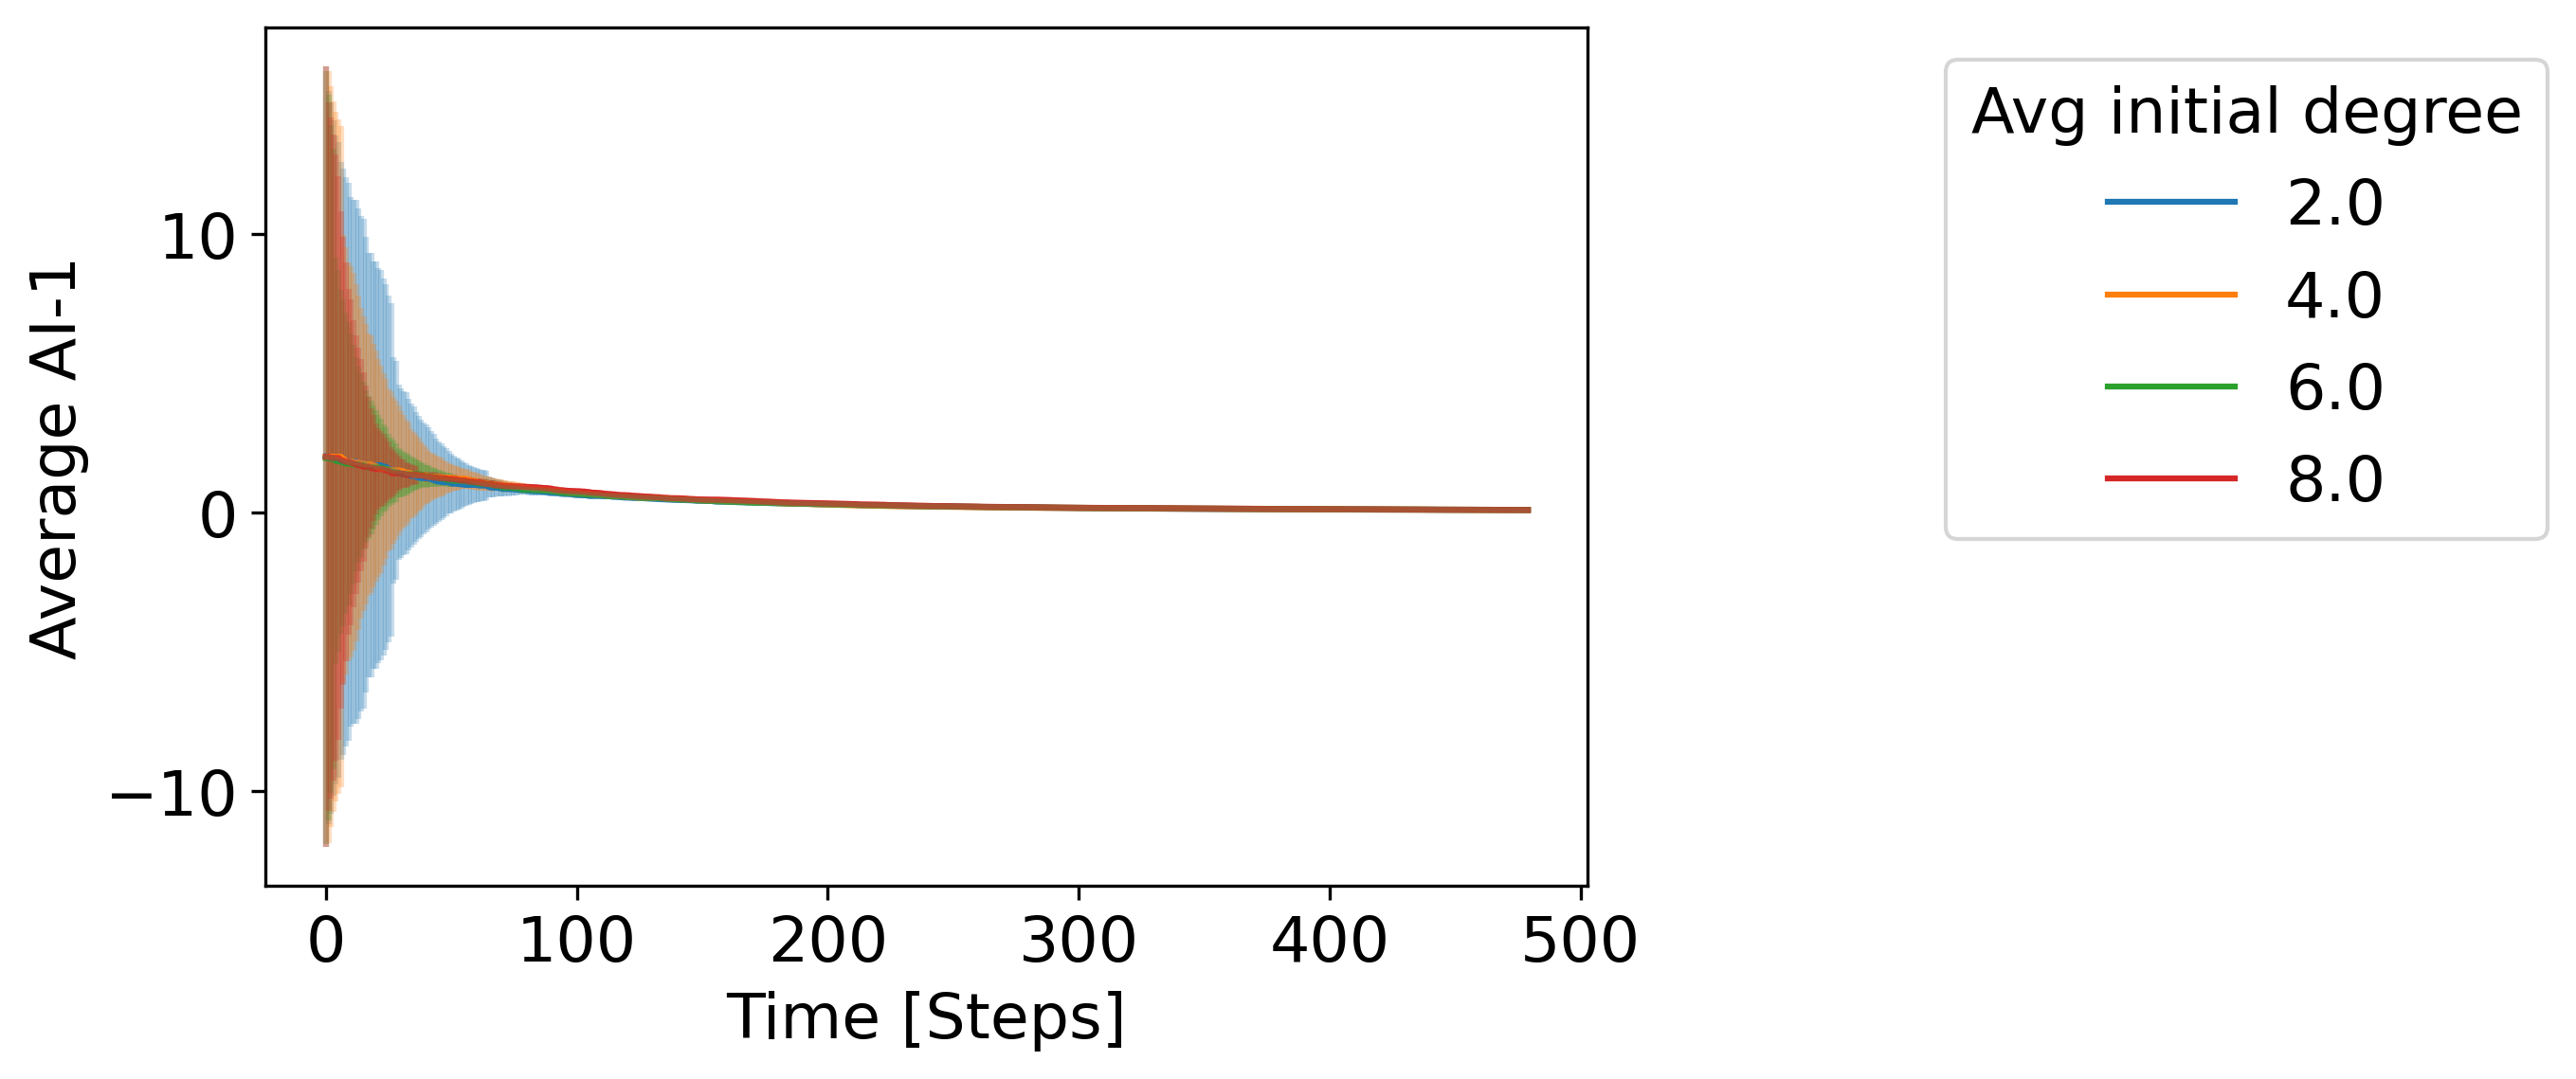

In [44]:
for x in range(4):
  plt.errorbar(x = range(480), y = hrangrowth_mean[x], yerr = hrangrowth_stdev[x], alpha = 0.25, color=colors[x])
  plt.plot(hrangrowth_mean[x], color=colors[x])
plt.title('')
plt.ylabel('Average AI-1')
plt.xlabel('Time [Steps]')
plt.legend([ki_data[x] for x in ki_data.keys()], title='Avg initial degree', bbox_to_anchor = [1.75,1])
plt.savefig('Random_Growth errplot',transparent=True, bbox_inches='tight')

# Diffusion+Growth+Random Edges from electrode

## Define network

In [46]:
#n=total nodes, m= total edges
def growth_diffusion_random_net(n,m,s):
  # Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'h':0, 's':s}})
    
  return G

## Initial state

In [47]:
#Initialize network to have L1 population and one electrode node
def initial_growth_diffusion_random_state(G):
    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'
    state[0] = 'Electrode'
    tot = G.number_of_nodes() - 1    
    G.nodes[0]['s'] = 0 #set substrate to zero so electrode never grows
    node_list = list(G.nodes)
    econtact = random.sample(node_list[1:], round(tot*0.25)) #25% of population is connected to the elctrode node
    for node in econtact:
        G.add_edge(0,node)    
    return state

## Transition state

In [48]:
def transition_growth_diffusion_random_state(G, current_state):
    next_state = {}
    #Randomize electrode connection
    tot = G.number_of_nodes()
    node_list = list(G.nodes)
    if round(tot*0.25) <= 130:
        econtact = random.sample(node_list[1:], round(tot*0.25))
    else:
        econtact = random.sample(node_list[1:], 130)
    
    #Electrode makes pe
    if transition_growth_diffusion_random_state.counter < 30:
        G.nodes[0]['h'] += 40
    
    J = G.copy()        
    for node in list(G.nodes):
        ci = J.nodes[node]['h'] #set current concentration of this node
        G.nodes[node]['h'] = ci + alpha * (\
                                        sum(J.nodes[j]['h'] for j in J.neighbors(node))\
                                        -ci * J.degree(node)) *Dt
    
    #Randomize edges between all nodes
    m = G.number_of_edges() - len(G.edges(0))
    G.remove_edges_from(G.edges())
    edges = [comb for comb in combinations(node_list[1:],2)]
    new_edges = random.sample(edges, m)
    G.add_edges_from(new_edges)
    for e in econtact:
        G.add_edge(0,e)
      
    if transition_growth_diffusion_random_state.counter >= 30:
        growing = [x for x in G.nodes if G.nodes[x]['s'] >= 1]
        for g in growing:
            prob = gr
            if random.uniform(0,1) < prob:
                k = len(G.nodes) + 1
                neighbors = list(G.neighbors(g))
                if len(neighbors) <= 10:
                        G.add_edge(g,k)    
                        s_update = G.nodes[g]['s']/2
                        h_update = G.nodes[g]['h']/2
                        G.nodes[g]['s'] = s_update
                        G.nodes[g]['h'] = h_update
                        G.add_node(k, h = h_update, s = s_update)
                        for x in neighbors:
                            G.add_edge(k,x)
                        current_state[k] = current_state[g]

                else:
                        d_neighbors = random.sample(neighbors,10)
                        G.add_edge(g,k)    
                        s_update = G.nodes[g]['s']/2
                        h_update = G.nodes[g]['h']/2
                        G.add_node(k, h = h_update, s = s_update)
                        G.nodes[g]['s'] = s_update
                        G.nodes[g]['h'] = h_update
                        for x in d_neighbors:
                            G.add_edge(k,x)
                        current_state[k] = current_state[g]
    
    transition_growth_diffusion_random_state.counter += 1 
    next_state = current_state
    
    return next_state

## Simulation+plot

In [49]:
alpha = 1
Dt = 0.01
n = 50
gr = 0.01
h_data = {}
k_data = {}
total_nodes = {}
for k in range(5):
    transition_growth_diffusion_random_state.counter = 0
    G = growth_diffusion_random_net(n,n*(k+1),20)
    sim = Simulation(G, initial_growth_diffusion_random_state, transition_growth_diffusion_random_state)
    h = []
    avg_degree = []
    nodes = []
    for x in range(480):
        sim.run()
        h.append(nx.get_node_attributes(sim.graph(),'h'))
        avg_degree.append(sum([x*nx.degree_histogram(sim.graph())[x] for x in range(len(nx.degree_histogram(sim.graph())))])/sim.graph().number_of_nodes())
        nodes.append(sim.num_nodes())
    h_data[k] = h
    k_data[k] = avg_degree
    total_nodes[k] = nodes

1200.0000000000002
1200.0000000000005
1200.0000000000005
1200.0000000000005


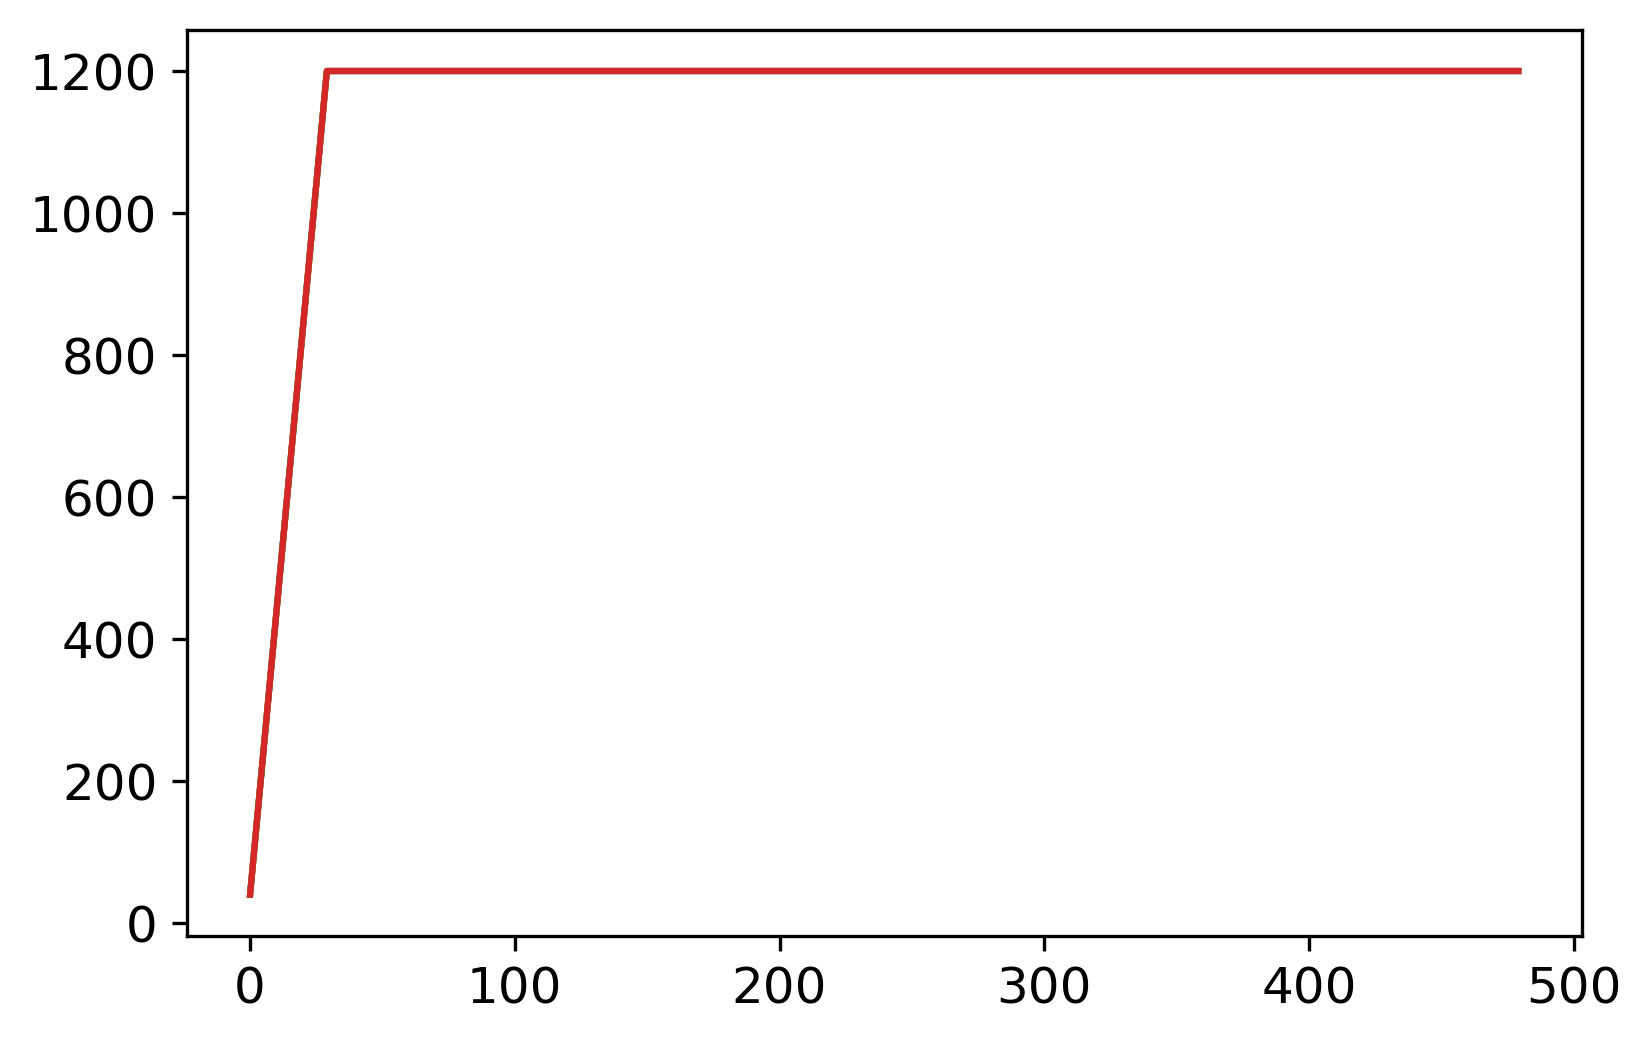

In [113]:
h_sum = {}
for key in h_data.keys():
  h = []
  for x in range(len(h_data[key])):
    h.append(np.sum(list(h_data[key][x].values())))
  h_sum[key] = h

for x in range(4):    
    plt.plot(h_sum[x])
    print(max(h_sum[x]))

In [50]:
hrangrowth_stdev = {}
for key in h_data.keys():
  stdevs = []
  for x in range(len(h_data[key])):
    stdevs.append(np.std(list(h_data[key][x].values())))
  hrangrowth_stdev[key] = stdevs

hrangrowth_mean = {}
for key in h_data.keys():
  avgs = []
  for x in range(len(h_data[key])):
    avgs.append(np.mean(list(h_data[key][x].values())))
  hrangrowth_mean[key] = avgs


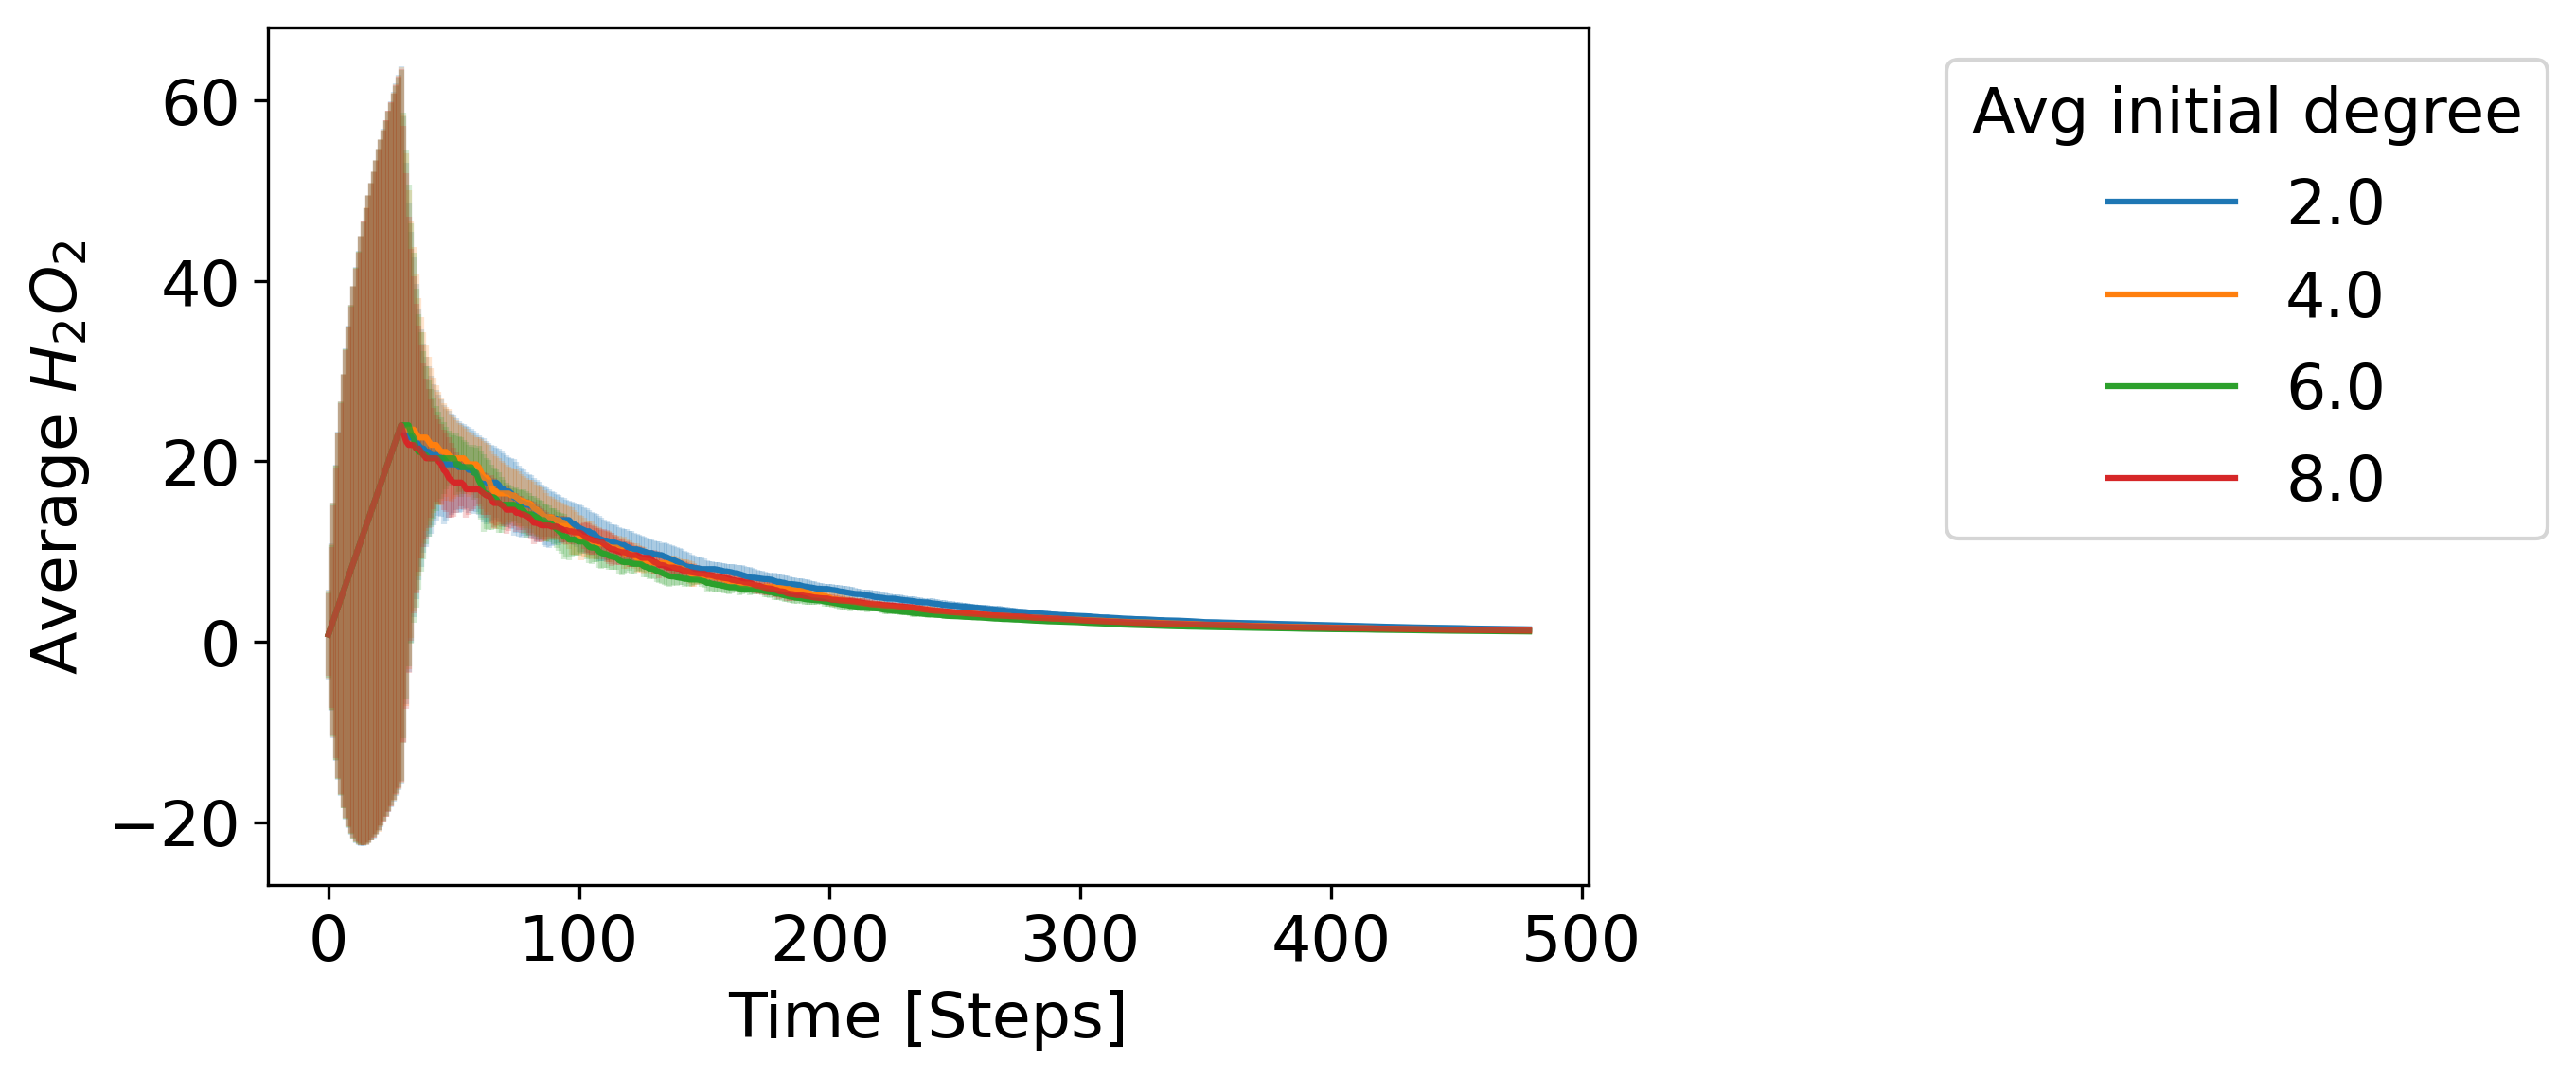

In [51]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for x in range(4):
  plt.errorbar(x = range(480), y = hrangrowth_mean[x], yerr = hrangrowth_stdev[x], alpha = 0.2, color=colors[x])
  plt.plot(range(480), hrangrowth_mean[x], color=colors[x])
plt.title('')
plt.ylabel('Average $H_{2}O_{2}$')
plt.xlabel('Time [Steps]')
plt.legend([ki_data[x] for x in ki_data.keys()], title='Avg initial degree', bbox_to_anchor = [1.75,1])
plt.savefig('Random Growth from electrode errplot',transparent=True, bbox_inches='tight')
#plt.xlim([0,30])
#plt.ylim([0,200])

ValueError: x and y must be the same size

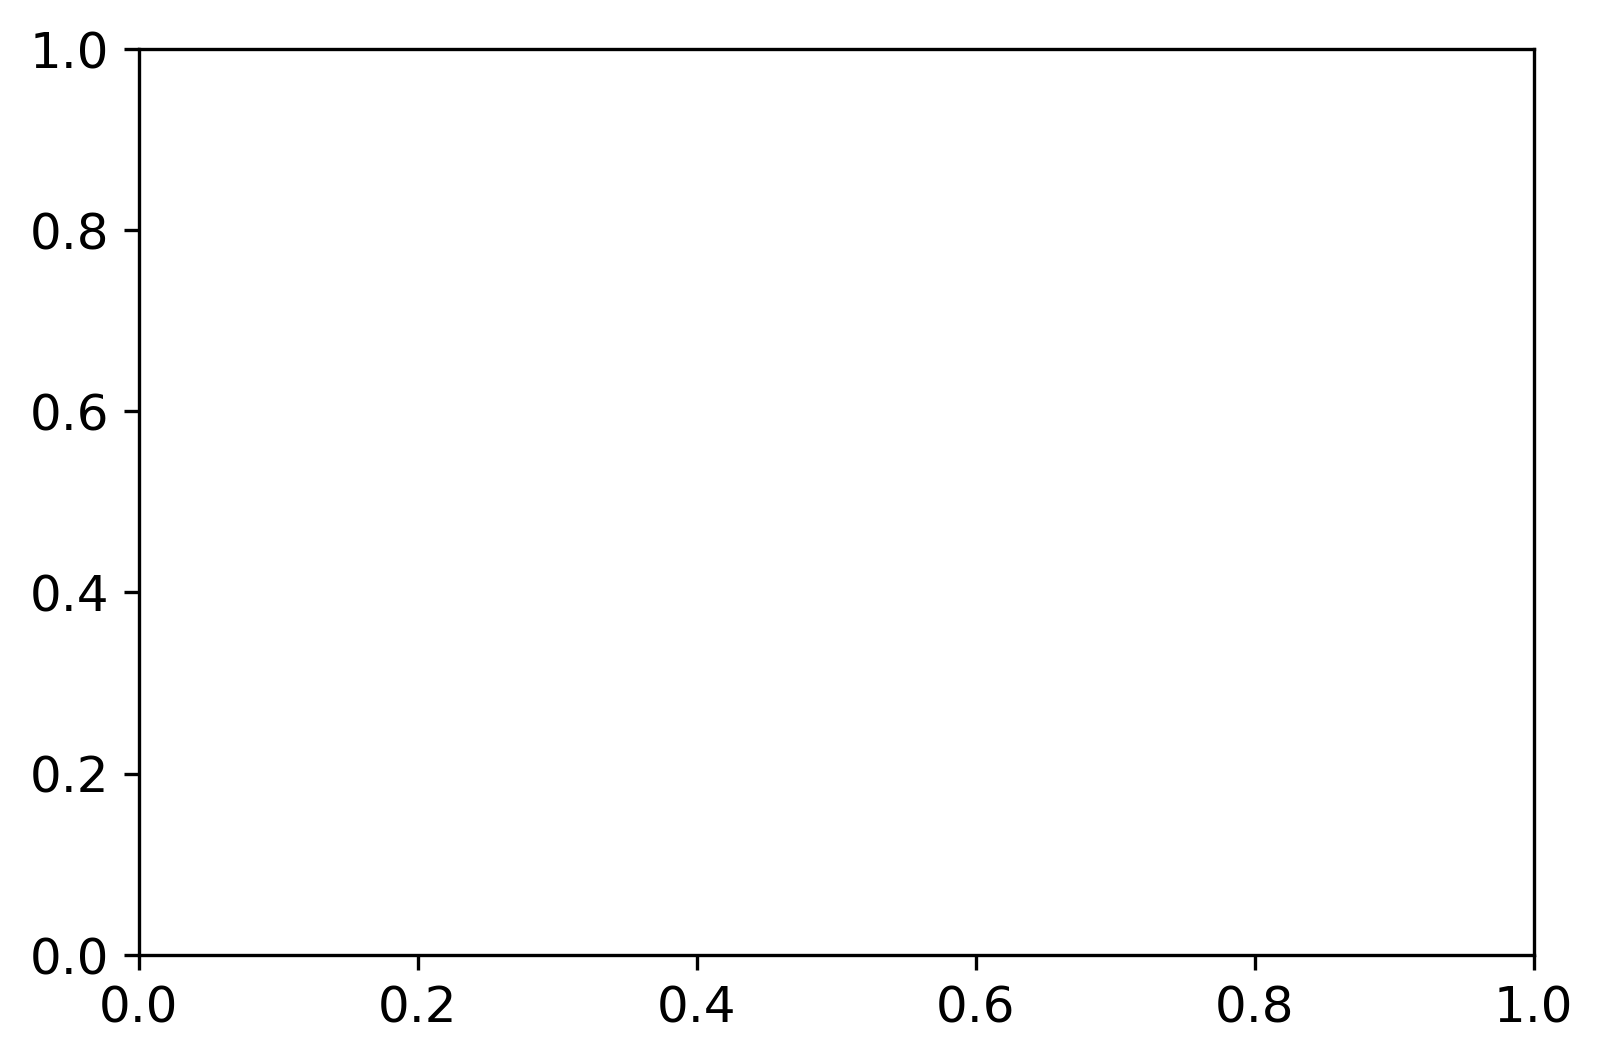

In [116]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for k in range(5):
  a = pd.DataFrame.from_dict(h_data[k])
  r = len(a.columns) - 1
  for x in range(1,r,1):
    plt.scatter(x=range(500), y=a[x],color=colors[k], alpha=0.2)
plt.legend([2,4,6,8,9])

In [ ]:
for key in total_nodes.keys():
  plt.plot(total_nodes[key])
plt.legend([x+1 for x in range(10)], title = 'Initial avg degree', loc='right')
plt.title('Growth+Diffusion+Random Edges Nodes')
plt.xlabel('Step')
plt.ylabel('Total Nodes')

In [ ]:
for key in k_data.keys():
  plt.plot(k_data[key])
plt.legend([k_data[x][0] for x in k_data.keys()], title = 'Initial avg degree', loc='right')
plt.title('Growth+Diffusion+Random Edges Average Degree')
plt.xlabel('Step')
plt.ylabel('Average Degree')
#plt.xlim([0,250])